# **Objective**: 
## Build a robust predictive model to estimate the `log_price` of homestay listings based on comprehensive analysis of their characteristics, amenities, and host information.
First make sure that the entire dataset is clean and ready to be used.

In [728]:
# supress warnings
import warnings
warnings.filterwarnings('ignore')

# data analysis and wrangling
import pandas as pd
import numpy as np

In [729]:
# import data
df = pd.read_csv('Homestays_Data.csv')
df_copy = df.copy()

In [730]:
# preview data
# df.head() to check the first 5 rows
# df.tail() to check the last 5 rows
dfo = df.copy()
df.tail()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
74106,14549287,4.605170,Apartment,Private room,{},1,1.0,Real Bed,flexible,False,...,40.709025,-73.939405,one room bushwick,Williamsburg,0,NaN,https://a0.muscache.com/im/pictures/55162426/6...,11206,1.0,1.0
74107,13281809,5.043425,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,2.0,Real Bed,moderate,True,...,33.871549,-118.396053,Spacious Hermosa 2 BR on PCH,Hermosa Beach,16,93.0,https://a0.muscache.com/im/pictures/2b86560b-a...,90254,2.0,4.0
74108,18688039,5.220356,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",5,1.0,Real Bed,moderate,True,...,40.706749,-73.942377,Modern 2 Bedroom Apartment in Williamsburg,Williamsburg,43,94.0,https://a0.muscache.com/im/pictures/7fbe448c-5...,11206,2.0,2.0
74109,17045948,5.273000,Apartment,Entire home/apt,"{TV,""Wireless Internet"",""Air conditioning"",Kit...",2,1.0,Real Bed,strict,True,...,40.738535,-74.000157,Designer's Apartment in HEART of NYC,West Village,0,NaN,https://a0.muscache.com/im/pictures/b3971b63-0...,10011,0.0,2.0
74110,3534845,4.852030,Boat,Entire home/apt,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",4,1.0,Real Bed,moderate,False,...,33.761096,-118.192409,Cozy Boat at Shoreline Village,Long Beach,205,96.0,https://a0.muscache.com/im/pictures/22968537/d...,90802,1.0,2.0


In [731]:
# checking data types for various features
# dtypes: bool(1), float64(7), int64(3), object(18)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [732]:
# initial size
df.shape

(74111, 29)

In [733]:
'''
checking which features contain blank, null or empty values:
We can check for missing values with pandas isnull(). 
This indicates whether values are missing or not. 
Then we can sum all the values to check every column.
'''
# df.isnull().sum()
round((df.isnull().sum()/df.shape[0])*100,2)

id                         0.00
log_price                  0.00
property_type              0.00
room_type                  0.00
amenities                  0.00
accommodates               0.00
bathrooms                  0.27
bed_type                   0.00
cancellation_policy        0.00
cleaning_fee               0.00
city                       0.00
description                0.00
first_review              21.41
host_has_profile_pic       0.25
host_identity_verified     0.25
host_response_rate        24.69
host_since                 0.25
instant_bookable           0.00
last_review               21.36
latitude                   0.00
longitude                  0.00
name                       0.00
neighbourhood              9.27
number_of_reviews          0.00
review_scores_rating      22.56
thumbnail_url             11.09
zipcode                    1.30
bedrooms                   0.12
beds                       0.18
dtype: float64

In [734]:
# handling the null values: 
# drop the thumbnail_url and zipcode as they are not important factors

df = df.drop(columns='id')
df = df.drop(columns='name')
df = df.drop(columns='thumbnail_url')
df = df.drop(columns='zipcode')

# drop null rows whose observation columns having null values
df = df[~pd.isnull(df['bathrooms'])]
df = df[~pd.isnull(df['first_review'])]
df = df[~pd.isnull(df['host_has_profile_pic'])]
df = df[~pd.isnull(df['host_identity_verified'])]
df = df[~pd.isnull(df['host_since'])]
df = df[~pd.isnull(df['last_review'])]
df = df[~pd.isnull(df['neighbourhood'])]
df = df[~pd.isnull(df['bedrooms'])]
df = df[~pd.isnull(df['beds'])]

# dropping rows having less than 450 entries as it won't affect log_price much
df = df.groupby("property_type").filter(lambda x: len(x)>=450)

df.shape

(50753, 25)

In [735]:
# replacing unwanted symbols of object and converting to int64
df['host_response_rate'] = df['host_response_rate'].replace({'%':''}, regex=True)
df['host_response_rate'] = df['host_response_rate'].fillna(0)
df = df.astype({'host_response_rate': int})
df['host_response_rate']

0          0
1        100
2        100
4        100
5        100
        ... 
74097    100
74100    100
74103    100
74107    100
74108    100
Name: host_response_rate, Length: 50753, dtype: int32

In [736]:
'''
Inputing the missing values from past observations.
Again, “missingness” is almost always informative in itself, and you should tell your algorithm if a value was missing by reinforcing the patterns already provided by other features.
Mean imputation or Median imputations is used here.
Note: 
Mean imputation is suitable when the data is normally distributed and has no extreme outliers.
Median imputation is preferable when the data contains outliers or is skewed.
'''
# performing mean imputation for observations having % null between 9% and 25%
df = df.fillna(df.host_response_rate.mean())
df = df.fillna(df.review_scores_rating.mean())

df.shape

(50753, 25)

In [737]:
# recheck if the data is cleaned or not
# df.isnull().sum()
round((df.isnull().sum()/df.shape[0])*100,2)

log_price                 0.0
property_type             0.0
room_type                 0.0
amenities                 0.0
accommodates              0.0
bathrooms                 0.0
bed_type                  0.0
cancellation_policy       0.0
cleaning_fee              0.0
city                      0.0
description               0.0
first_review              0.0
host_has_profile_pic      0.0
host_identity_verified    0.0
host_response_rate        0.0
host_since                0.0
instant_bookable          0.0
last_review               0.0
latitude                  0.0
longitude                 0.0
neighbourhood             0.0
number_of_reviews         0.0
review_scores_rating      0.0
bedrooms                  0.0
beds                      0.0
dtype: float64

# 1. Feature Engineering:
# Task: Enhance the dataset by creating actionable and insightful features. 
Calculate `Host_Tenure` by determining the number of years from `host_since` to the current date, providing a measure of host experience. Generate `Amenities_Count` by counting the items listed in the `amenities` array to quantify property offerings. Determine `Days_Since_Last_Review` by calculating the days between `last_review` and today to assess listing activity and relevance.

In [738]:
# host and amenities features: 
# adding necessary columns
df.insert(0, 'host_tenure', 0)
df.insert(1, 'days_since_last_review', 0)

In [739]:
# Filling the added columns
today_date = pd.to_datetime(pd.to_datetime("today").date())

# host_tenure
df['host_since'] = pd.to_datetime(df['host_since'])
df['host_tenure'] = (today_date - df['host_since'])
df['host_tenure'] = df[['host_tenure']].apply(pd.to_numeric)
df['host_tenure'] = df['host_tenure']/(24*60*60*1e9)
df['host_tenure'] = df['host_tenure'].astype(int)

# days_since_last_review
df['last_review'] = pd.to_datetime(df['last_review'])
df['days_since_last_review'] = (today_date - df['last_review'])
df['days_since_last_review'] = df[['days_since_last_review']].apply(pd.to_numeric)
df['days_since_last_review'] = df['days_since_last_review']/(24*60*60*1e9)
df['days_since_last_review'] = df['days_since_last_review'].astype(int)


In [740]:
# # extract amenities
# amenities_list = []
# for i in range(len(df['amenities'].unique())):
#     if not pd.isnull(df['amenities'].unique()[i]):
#         amenities = df['amenities'].unique()[i].split(",")
#         for ft in amenities:
#             if ft not in amenities_list:
#                 amenities_list.append(ft)
# amenities_list

####### commented out since running it takes quite a lot of time #######
''' 
amenities_list = ['{"Wireless Internet"',
 '"Air conditioning"',
 'Kitchen',
 'Heating',
 '"Family/kid friendly"',
 'Essentials',
 '"Hair dryer"',
 'Iron',
 '"translation missing: en.hosting_amenity_50"}',
 'Washer',
 'Dryer',
 '"Smoke detector"',
 '"Fire extinguisher"',
 'Shampoo',
 'Hangers',
 '{TV',
 '"Cable TV"',
 '"Wireless Internet"',
 'Breakfast',
 '"Buzzer/wireless intercom"',
 '"Carbon monoxide detector"',
 '"Laptop friendly workspace"',
 'Internet',
 '"Elevator in building"',
 'Shampoo}',
 '"First aid kit"',
 '"Laptop friendly workspace"}',
 '"Wheelchair accessible"',
 'Pool',
 '"Free parking on premises"',
 'Doorman',
 'Dog(s)',
 'Cat(s)',
 '"Other pet(s)"',
 '"Hot tub"',
 '"Lock on bedroom door"',
 '"Hair dryer"}',
 '"Pets live on this property"',
 '"Private entrance"',
 '"Hot water"',
 '"Bed linens"',
 '"Extra pillows and blankets"',
 '"Coffee maker"',
 'Refrigerator',
 '"Dishes and silverware"',
 '"Garden or backyard"}',
 '{Internet',
 '"Pets allowed"',
 '"Safety card"',
 '"24-hour check-in"',
 '"Self Check-In"',
 'Lockbox}',
 '"Suitable for events"',
 '"translation missing: en.hosting_amenity_49"',
 'Elevator',
 'Microwave',
 '"Cooking basics"',
 'Oven',
 'Stove}',
 '{"Cable TV"',
 '"Smoking allowed"',
 'Gym',
 '"Outlet covers"',
 'Bathtub',
 'Dishwasher',
 'Stove',
 '"Single level home"',
 '"Luggage dropoff allowed"',
 '"Step-free access"',
 '"Wide clearance to bed"',
 '"Accessible-height bed"',
 '"Wide doorway"',
 '"Accessible-height toilet"',
 '"Wide entryway"',
 '"Hot water kettle"}',
 '"translation missing: en.hosting_amenity_49"}',
 'Lockbox',
 '"Babysitter recommendations"',
 '"Pack ’n Play/travel crib"}',
 'Iron}',
 '"Indoor fireplace"',
 '"translation missing: en.hosting_amenity_50"',
 '"Free parking on street"',
 '"Smart lock"}',
 '"Luggage dropoff allowed"}',
 '"Wide hallway clearance"',
 '"Flat',
 ' smooth pathway to front door"',
 '"Well-lit path to entrance"}',
 '"Long term stays allowed"}',
 '"Smoke detector"}',
 '"Private living room"}',
 '"Children’s books and toys"',
 '"Children’s dinnerware"',
 '"BBQ grill"',
 '"Patio or balcony"',
 '"Garden or backyard"',
 '"Private entrance"}',
 'Bathtub}',
 '"First aid kit"}',
 '"Host greets you"}',
 'Smartlock',
 '"Babysitter recommendations"}',
 'Dryer}',
 'Heating}',
 '{"Smoke detector"',
 'Hangers}',
 '"Lock on bedroom door"}',
 '"High chair"',
 '{"Air conditioning"',
 '"Ethernet connection"',
 '"Family/kid friendly"}',
 '"Room-darkening shades"',
 '"Long term stays allowed"',
 '"Wide hallway clearance"}',
 '{"Family/kid friendly"',
 'Doorman}',
 'TV}',
 '"Private living room"',
 '"Changing table"',
 '"Stair gates"',
 '"Window guards"',
 '"Table corner guards"',
 'Crib',
 'Other}',
 '"Private bathroom"',
 '"Doorman Entry"}',
 '{Heating',
 'Essentials}',
 '"Baby monitor"',
 '"Baby bath"',
 '"Fireplace guards"',
 '"Pack ’n Play/travel crib"',
 '"Game console"}',
 'Smartlock}',
 '"Bed linens"}',
 '"Well-lit path to entrance"',
 '"Firm mattress"',
 '"Step-free access"}',
 '"Extra pillows and blankets"}',
 '{}',
 '"Room-darkening shades"}',
 'Keypad}',
 'Keypad',
 '"Patio or balcony"}',
 '"Hot water"}',
 '"Fire extinguisher"}',
 '"Host greets you"',
 '"Handheld shower head"}',
 '"Smart lock"',
 '"24-hour check-in"}',
 '{"translation missing: en.hosting_amenity_49"',
 '"Fireplace guards"}',
 '"Cleaning before checkout"}',
 'Waterfront}',
 '"Wide entryway"}',
 'Refrigerator}',
 '"Ground floor access"',
 '"Cleaning before checkout"',
 '"Accessible-height toilet"}',
 '"Game console"',
 '"Accessible-height bed"}',
 '"Children’s dinnerware"}',
 '"Ethernet connection"}',
 'Oven}',
 '{Kitchen',
 '"Carbon monoxide detector"}',
 '"Beach essentials"',
 '"Window guards"}',
 'Crib}',
 '{Doorman',
 '"Buzzer/wireless intercom"}',
 'Beachfront}',
 '"Firm mattress"}',
 '"Pocket wifi"}',
 '"Fixed grab bars for shower & toilet"',
 '"Bathtub with shower chair"',
 '"Wide clearance to shower & toilet"',
 '"EV charger"',
 '"Doorman Entry"',
 '"Wide doorway"}',
 '"Beach essentials"}',
 '"Dishes and silverware"}',
 'Waterfront',
 '"Lake access"}',
 '"Cooking basics"}',
 '{"translation missing: en.hosting_amenity_50"',
 '{Essentials}',
 '{"Smoking allowed"',
 '"Handheld shower head"',
 '{"Family/kid friendly"}',
 'Washer}',
 '"Single level home"}',
 '"Washer / Dryer"',
 '{"Host greets you"',
 '"Children’s books and toys"}',
 '"Safety card"}',
 '{Washer',
 '"Wireless Internet"}',
 '"Fixed grab bars for shower & toilet"}',
 '"Pocket wifi"',
 'TV',
 '{Stove',
 ' smooth pathway to front door"}',
 '"Disabled parking spot"',
 '{"Suitable for events"',
 'Other',
 '"Outlet covers"}',
 '{"Pets live on this property"}',
 '"Free parking on premises"}',
 '"Roll-in shower with chair"}',
 '"Table corner guards"}',
 '"Hot water kettle"',
 '"Air purifier"}',
 '"BBQ grill"}',
 '"Lake access"',
 'Beachfront',
 '"Ski in/Ski out"}',
 '"Path to entrance lit at night"}',
 '{"Lock on bedroom door"',
 '"Suitable for events"}',
 '{TV}',
 'Kitchen}',
 '{"Pets allowed"',
 '"High chair"}',
 '"Firm matress"',
 '{"Free parking on premises"',
 '"Pets live on this property"}',
 '"Private bathroom"}',
 '"Wide clearance to shower & toilet"}',
 '"EV charger"}',
 '"Wide clearance to bed"}',
 '{"Pets live on this property"',
 'Dog(s)}',
 '"Paid parking off premises"',
 '"Flat smooth pathway to front door"',
 '{"Wide entryway"',
 '"Baby bath"}',
 '"Path to entrance lit at night"',
 '"Stair gates"}',
 '"Changing table"}',
 '"Ground floor access"}',
 'Microwave}',
 '{"Wireless Internet"}',
 '"Roll-in shower with chair"',
 '{"Single level home"',
 '{Gym',
 '{Pool',
 '{"translation missing: en.hosting_amenity_50"}',
 '{"translation missing: en.hosting_amenity_49"}',
 '"Body soap"',
 '"Hand soap"',
 '"Bath towel"',
 '"Hand or paper towel"',
 '"Toilet paper"',
 '"Air conditioning"}',
 '{Kitchen}',
 '"Coffee maker"}',
 'Dishwasher}',
 'Elevator}',
 '"Bathtub with shower chair"}',
 '"Hot tub"}',
 '{"Pets allowed"}',
 '"Wide clearance to shower and toilet"',
 '{Shampoo',
 '{"Wheelchair accessible"',
 'Cat(s)}',
 '{Breakfast',
 '{Essentials',
 '"Disabled parking spot"}',
 'Breakfast}',
 '"Other pet(s)"}',
 '{"Self Check-In"',
 '{"Smoking allowed"}',
 '{"Laptop friendly workspace"}',
 '"Indoor fireplace"}',
 '{"Smoke detector"}',
 '{"Stair gates"',
 '{"Elevator in building"',
 '"Firm matress"}',
 '"Pets allowed"}',
 '"Grab-rails for shower and toilet"}']
'''

' \namenities_list = [\'{"Wireless Internet"\',\n \'"Air conditioning"\',\n \'Kitchen\',\n \'Heating\',\n \'"Family/kid friendly"\',\n \'Essentials\',\n \'"Hair dryer"\',\n \'Iron\',\n \'"translation missing: en.hosting_amenity_50"}\',\n \'Washer\',\n \'Dryer\',\n \'"Smoke detector"\',\n \'"Fire extinguisher"\',\n \'Shampoo\',\n \'Hangers\',\n \'{TV\',\n \'"Cable TV"\',\n \'"Wireless Internet"\',\n \'Breakfast\',\n \'"Buzzer/wireless intercom"\',\n \'"Carbon monoxide detector"\',\n \'"Laptop friendly workspace"\',\n \'Internet\',\n \'"Elevator in building"\',\n \'Shampoo}\',\n \'"First aid kit"\',\n \'"Laptop friendly workspace"}\',\n \'"Wheelchair accessible"\',\n \'Pool\',\n \'"Free parking on premises"\',\n \'Doorman\',\n \'Dog(s)\',\n \'Cat(s)\',\n \'"Other pet(s)"\',\n \'"Hot tub"\',\n \'"Lock on bedroom door"\',\n \'"Hair dryer"}\',\n \'"Pets live on this property"\',\n \'"Private entrance"\',\n \'"Hot water"\',\n \'"Bed linens"\',\n \'"Extra pillows and blankets"\',\n \'"Coffee 

In [741]:
# df.insert(2, 'amenities_count', 0)
# enable_separate_amenities = 1
# # assign 0 to all the above amenities
# for i in range(len(amenities_list)):
#     ft = amenities_list[i]
#     df[ft] = 0

    
# if enable_separate_amenities == 1:
#     # assign 1 if those amenities are present
#     for i in range(len(df)):
#         idx = df.index[i]
#         amenities = dfo.loc[idx]["amenities"]
#         if not pd.isnull(amenities):
#             amenities = amenities.split(",")
#             for ft in amenities:
#                 df.at[idx, ft] = 1 

In [742]:
df['amenities']

0        {"Wireless Internet","Air conditioning",Kitche...
1        {"Wireless Internet","Air conditioning",Kitche...
2        {TV,"Cable TV","Wireless Internet","Air condit...
4        {TV,Internet,"Wireless Internet","Air conditio...
5        {TV,"Wireless Internet",Heating,"Smoke detecto...
                               ...                        
74097    {Internet,"Wireless Internet","Air conditionin...
74100    {Internet,"Wireless Internet","Air conditionin...
74103    {TV,"Cable TV",Internet,"Wireless Internet","A...
74107    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
74108    {TV,Internet,"Wireless Internet","Air conditio...
Name: amenities, Length: 50753, dtype: object

In [743]:
# dropping unecessary columns
df = df.drop(columns='amenities')
df = df.drop(columns='host_since')
df = df.drop(columns='first_review')
df = df.drop(columns='last_review')
df = df.drop(columns='neighbourhood')
df = df.drop(columns='description')
df.head()

,host_tenure,days_since_last_review,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
0,4425,2850,5.010635,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,...,t,t,0,f,40.696524,-73.991617,2,100.0,1.0,1.0
1,2514,2418,5.129899,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,...,t,f,100,t,40.766115,-73.989040,6,93.0,3.0,3.0
2,2751,2427,4.976734,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,...,t,t,100,t,40.808110,-73.943756,10,92.0,1.0,3.0
4,3355,2662,4.744932,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,...,t,t,100,t,38.925627,-77.034596,4,40.0,0.0,1.0
5,2526,2436,4.442651,Apartment,Private room,2,1.0,Real Bed,strict,True,...,t,t,100,t,37.753164,-122.429526,3,100.0,1.0,1.0


# 6. Categorical Data Encoding:
## Task: Convert categorical data into a format suitable for machine learning analysis. 
Apply one-hot encoding to variables like `room_type`, `city`, and `property_type`, ensuring that the model can interpret these as 
distinct features without any ordinal implication.

In [744]:
# building the pearson correlation matrix to get the correlation values between different observations and log_price after performing encoding to convert string into int or float
''' 
Pearson correlation matrix¶
We use the Pearson correlation coefficient to examine the strength and direction of the linear relationship between two continuous variables.

The correlation coefficient can range in value from −1 to +1. The larger the absolute value of the coefficient, the stronger the relationship between the variables. For the Pearson correlation, an absolute value of 1 indicates a perfect linear relationship. A correlation close to 0 indicates no linear relationship between the variables.

The sign of the coefficient indicates the direction of the relationship. If both variables tend to increase or decrease together, the coefficient is positive, and the line that represents the correlation slopes upward. If one variable tends to increase as the other decreases, the coefficient is negative, and the line that represents the correlation slopes downward.
'''
# Extract categorical columns from the dataframe
# Here we extract the columns with object datatype as they are the categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()


   host_tenure  days_since_last_review  log_price  accommodates  bathrooms  \
0       4425.0                  2850.0   5.010635           3.0        1.0   
1       2514.0                  2418.0   5.129899           7.0        1.0   
2       2751.0                  2427.0   4.976734           5.0        1.0   
4       3355.0                  2662.0   4.744932           2.0        1.0   
5       2526.0                  2436.0   4.442651           2.0        1.0   

  cleaning_fee  host_response_rate   latitude   longitude  number_of_reviews  \
0         True                 0.0  40.696524  -73.991617                2.0   
1         True               100.0  40.766115  -73.989040                6.0   
2         True               100.0  40.808110  -73.943756               10.0   
4         True               100.0  38.925627  -77.034596                4.0   
5         True               100.0  37.753164 -122.429526                3.0   

   ...  city_DC  city_LA  city_NYC  city_SF  host_

<Axes: title={'center': 'Pearson Correlation Matrix (One-Hot Encoded)'}>

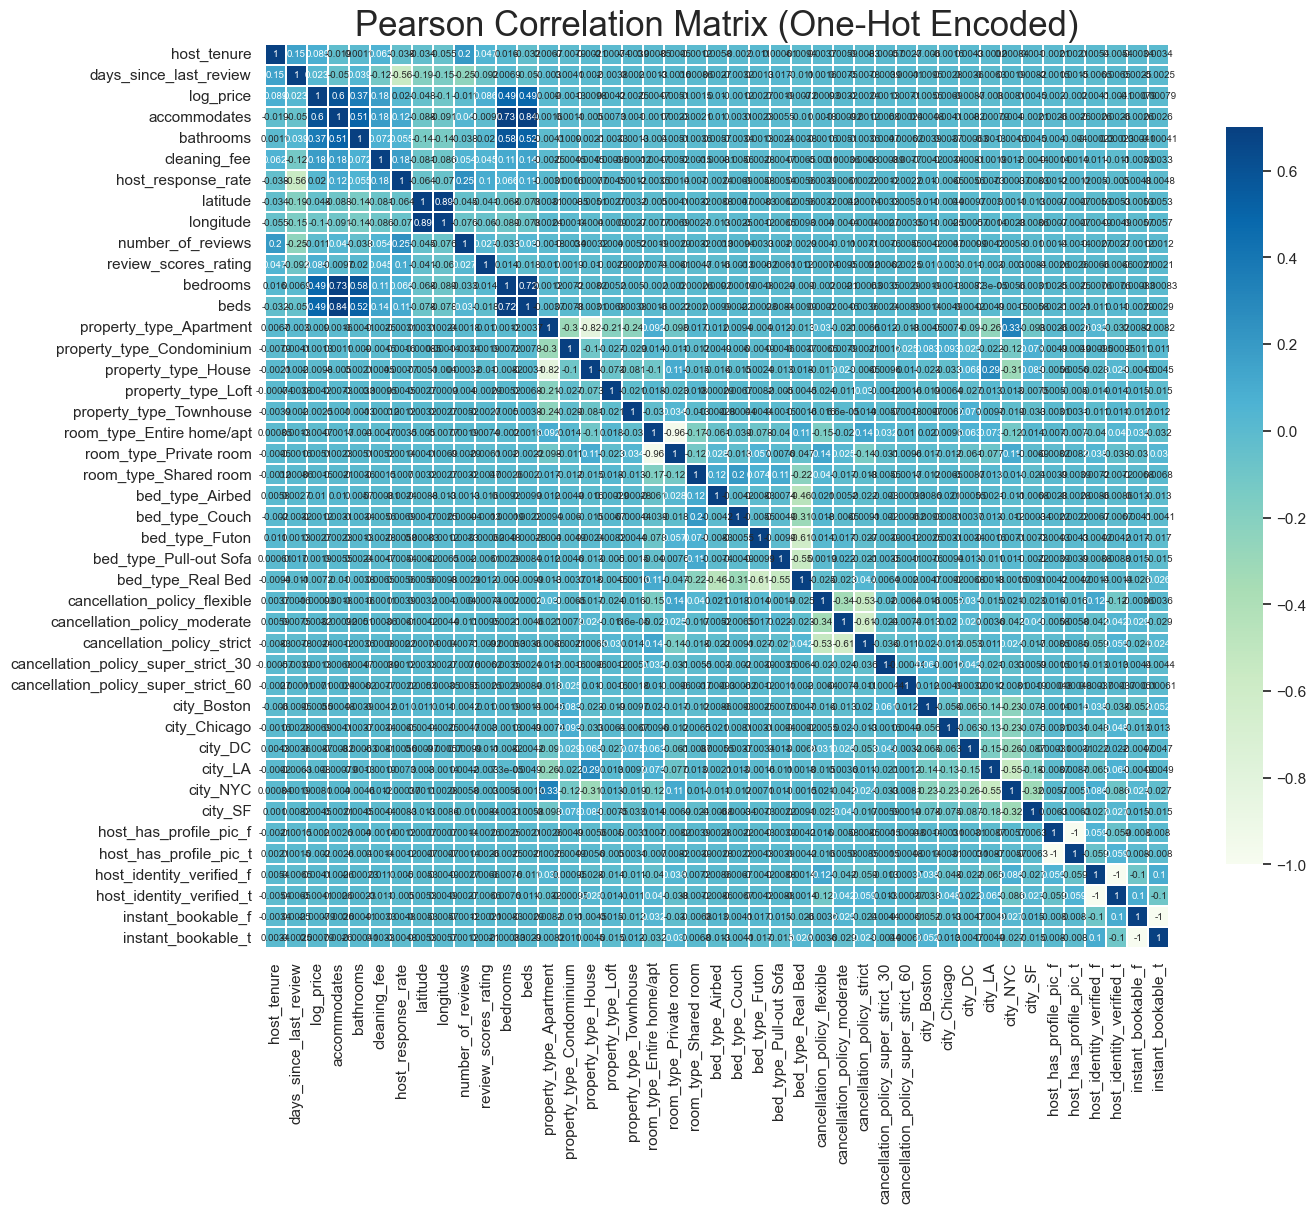

In [745]:
# performing one-hot-encoding
# Concatenate the one-hot encoded dataframe with the original dataframe
# Drop the original categorical columns (66748-15995 = 50753)
dfco = df.copy()
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = one_hot_encoder.fit_transform(dfco[categorical_columns])
one_hot_dfco = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_columns))
dfco_encoded = pd.concat([dfco, one_hot_dfco], axis=1)
dfco_encoded = dfco_encoded.drop(categorical_columns, axis=1)
dfco = dfco_encoded[~pd.isnull(dfco_encoded)]
dfco.dropna()
print(dfco.head())

# print the pearson corr matrix
sns.set(style="whitegrid", font_scale=1)
plt.figure(figsize=(13,13))
plt.title('Pearson Correlation Matrix (One-Hot Encoded)',fontsize=25)
sns.heatmap(dfco.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="GnBu",linecolor='w',
            annot=True, annot_kws={"size":7}, cbar_kws={"shrink": .7})

# disadvantage becasue it adds on to more number of columns, hence interprating data becomes tougher and also the processing time increases

   host_tenure  days_since_last_review  log_price  property_type  room_type  \
0         4425                    2850   5.010635              0          0   
1         2514                    2418   5.129899              0          0   
2         2751                    2427   4.976734              0          0   
4         3355                    2662   4.744932              0          0   
5         2526                    2436   4.442651              0          1   

   accommodates  bathrooms  bed_type  cancellation_policy  cleaning_fee  ...  \
0             3        1.0         4                    2          True  ...   
1             7        1.0         4                    2          True  ...   
2             5        1.0         4                    1          True  ...   
4             2        1.0         4                    1          True  ...   
5             2        1.0         4                    2          True  ...   

   host_has_profile_pic  host_identity_verif

<Axes: title={'center': 'Pearson Correlation Matrix (Label Encoded)'}>

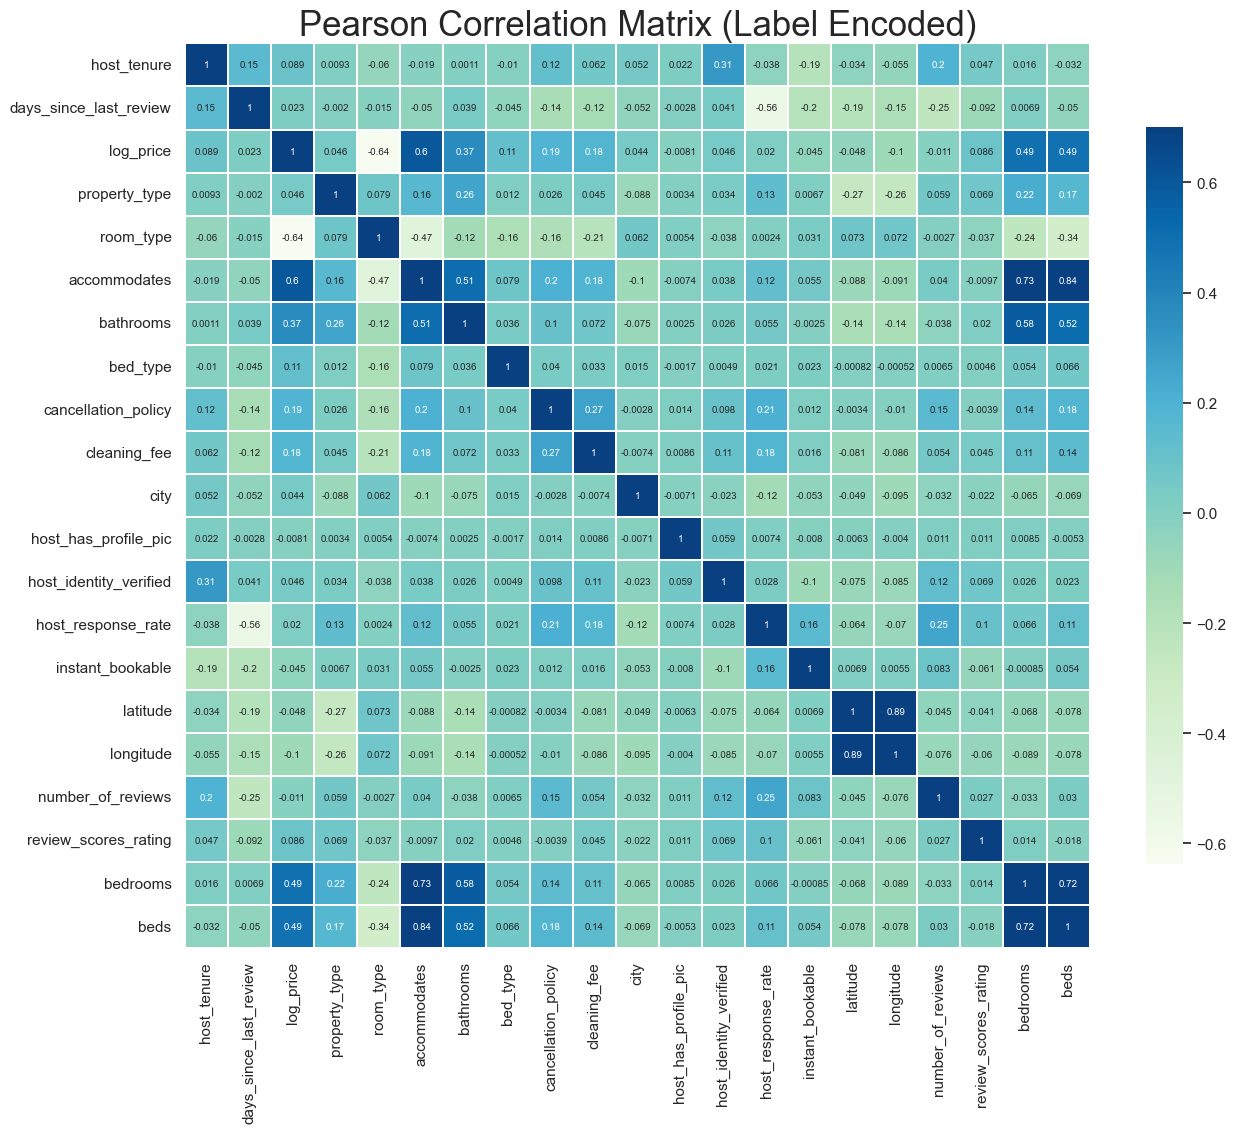

In [746]:
# performing label encoder
dfcl = df.copy()
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for column in categorical_columns:
    dfcl[column] = label_encoder.fit_transform(dfcl[column])
print(dfcl.head())

# print the pearson corr matrix
sns.set(style="whitegrid", font_scale=1)
plt.figure(figsize=(13,13))
plt.title('Pearson Correlation Matrix (Label Encoded)',fontsize=25)
sns.heatmap(dfcl.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="GnBu",linecolor='w',
            annot=True, annot_kws={"size":7}, cbar_kws={"shrink": .7})

# better to understand and compartively less complex appearing than than the one hot encoded pearson matrix

# 2. Exploratory Data Analysis (EDA):

## Task: Conduct a deep dive into the dataset to uncover underlying patterns and relationships. 
Analyze how pricing (`log_price`) correlates with both categorical (such as `room_type` and `property_type`) and numerical features (like `accommodates` and `number_of_reviews`). Utilize statistical tools and visualizations such as correlation matrices, histograms for distribution analysis, and scatter plots to explore relationships between variables.

In [747]:
import seaborn as sns
import matplotlib.pyplot as plt
print(df.isnull().sum())
print(df.info)

host_tenure               0
days_since_last_review    0
log_price                 0
property_type             0
room_type                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
host_has_profile_pic      0
host_identity_verified    0
host_response_rate        0
instant_bookable          0
latitude                  0
longitude                 0
number_of_reviews         0
review_scores_rating      0
bedrooms                  0
beds                      0
dtype: int64
<bound method DataFrame.info of        host_tenure  days_since_last_review  log_price property_type  \
0             4425                    2850   5.010635     Apartment   
1             2514                    2418   5.129899     Apartment   
2             2751                    2427   4.976734     Apartment   
4             3355                    2662   4.744932     Apartment   
5           

In [748]:
''' 
Univariate analysis:
Is used to explore each variable in a data set, separately. It looks at the range of values, as well as the central tendency of the values. It describes the pattern of response to the variable. It describes each variable on its own. Descriptive statistics describe and summarize data.
'''
# here done with Histograms
# based on city with property_type, room_type

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib
font = {'family':'Georgia', 'weight':'normal', 'size':14}
matplotlib.rc('font', **font)
df.columns

Index(['host_tenure', 'days_since_last_review', 'log_price', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bed_type',
       'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'instant_bookable',
       'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating',
       'bedrooms', 'beds'],
      dtype='object')

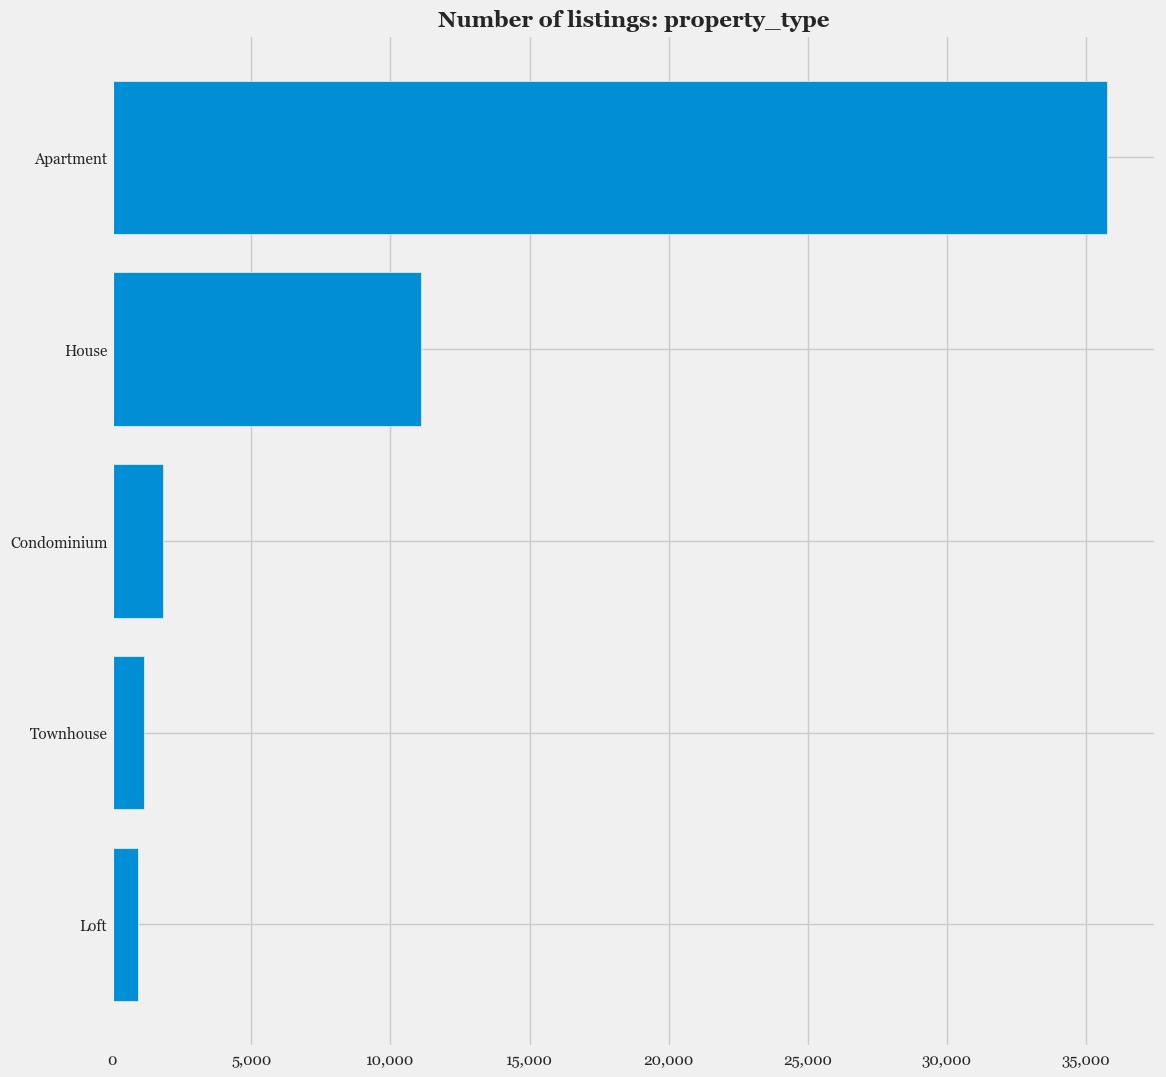

In [749]:
''' 
number of room listings preferences with the property_types which shows that nost preference goes to the apartment in majority of the cities with very very few importances given to exotic types i.e. near 0 preferences (not by mass number of people)
'''

dfp = df.groupby("property_type").count()["city"].reset_index().sort_values("city", ascending=False)
plt.figure(figsize=(12,12.5))
plt.barh(dfp["property_type"], dfp["city"])
ax = plt.gca()
ax.invert_yaxis()
plt.title("Number of listings: property_type", fontsize=16, fontweight="bold") 
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

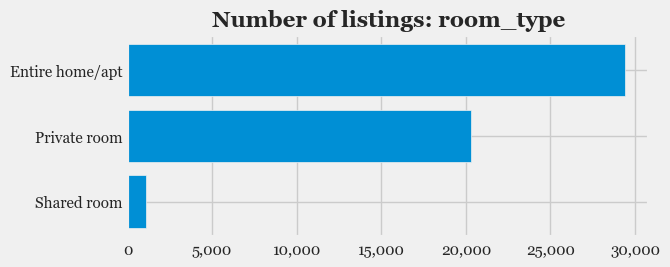

In [750]:
'''
number of room listings preferences with the room_types which shows that nost preference goes to the entire apartment in majority of the cities
'''
dfr = df.groupby("room_type").count()["city"].reset_index().sort_values("city", ascending=False)
plt.figure(figsize=(6,2.5))
plt.barh(dfr["room_type"], dfr["city"])
ax = plt.gca()
ax.invert_yaxis()
plt.title("Number of listings: room_type", fontsize=16, fontweight="bold") 
ax.get_xaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

In [751]:
# Bivariate analysis: refers to the analysis of two variables to determine relationships between them.
''' 
here correlation with log_price is performed with:
# categorical features: 
    log_price & property_type
    log_price & room_type
    log_price & bed_type
    log_price & city
    log_price & neighbourhood -> removed

# numerical features:
    log_price & accomodates
    log_price & bathrooms
    log_price & number_of_reviews
    log_price & review_scores_rating
    log_price & bedrooms
    log_price & beds
    log_price & amenities -> removed

# host features:
    log_price & host_has_profile_pic
    log_price & host_identity_verified
    log_price & host_response_rate
    log_price & instant_bookable
    log_price & review_scores_rating

'''

' \nhere correlation with log_price is performed with:\n# categorical features: \n    log_price & property_type\n    log_price & room_type\n    log_price & bed_type\n    log_price & city\n    log_price & neighbourhood -> removed\n\n# numerical features:\n    log_price & accomodates\n    log_price & bathrooms\n    log_price & number_of_reviews\n    log_price & review_scores_rating\n    log_price & bedrooms\n    log_price & beds\n    log_price & amenities -> removed\n\n# host features:\n    log_price & host_has_profile_pic\n    log_price & host_identity_verified\n    log_price & host_response_rate\n    log_price & instant_bookable\n    log_price & review_scores_rating\n\n'

['Entire home/apt' 'Private room' 'Shared room']


Text(0.5, 0.98, 'Boxplot: Listing Price by property_type')

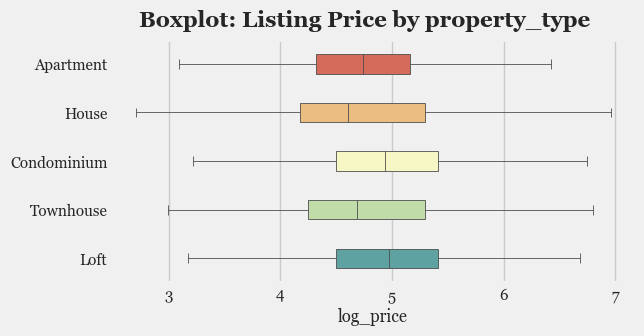

In [752]:
## categorical features:
    # log_price & property_type
    # log_price & room_type
    # log_price & bed_type
    # log_price & city
    # log_price & neighbourhood 

# correlation between log_price and property_type
print(df['room_type'].unique())
plt.figure(figsize=(6, 3))
dft = df[['property_type', 'log_price']]
sns.boxplot(x='log_price', y='property_type', data=dft, order=['Apartment', 'House', 'Condominium', 'Townhouse', 'Loft'], showfliers = False, palette='Spectral', linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle('Boxplot: Listing Price by property_type', fontweight='bold', fontsize=16)

['Apartment' 'Condominium' 'House' 'Loft' 'Townhouse']


Text(0.5, 0.98, 'Boxplot: Listing Price by room_type')

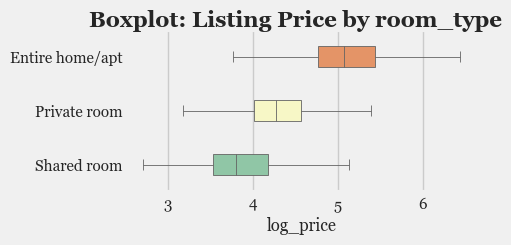

In [753]:
# correlation between log_price and room_type
print(df['property_type'].unique())
plt.figure(figsize=(4, 2))
dft = df[['room_type', 'log_price']]
sns.boxplot(x='log_price', y='room_type', data=dft, order=['Entire home/apt', 'Private room', 'Shared room'], showfliers = False, palette='Spectral', linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle('Boxplot: Listing Price by room_type', fontweight='bold', fontsize=16)

['Real Bed' 'Futon' 'Pull-out Sofa' 'Couch' 'Airbed']


Text(0.5, 0.98, 'Boxplot: Listing Price by bed_type')

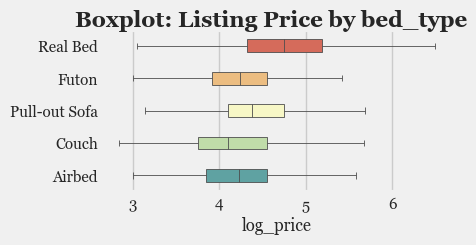

In [754]:
# correlation between log_price and bed_type
print(df['bed_type'].unique())
plt.figure(figsize=(4, 2))
dft = df[['bed_type', 'log_price']]
sns.boxplot(x='log_price', y='bed_type', data=dft, order=['Real Bed', 'Futon', 'Pull-out Sofa', 'Couch', 'Airbed'], showfliers = False, palette='Spectral', linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle('Boxplot: Listing Price by bed_type', fontweight='bold', fontsize=16)

['NYC' 'DC' 'SF' 'LA' 'Chicago' 'Boston']


Text(0.5, 0.98, 'Boxplot: Listing Price by city')

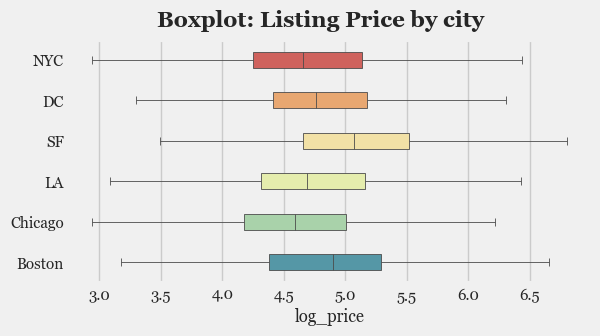

In [755]:
# correlation between log_price and city
print(df['city'].unique())
plt.figure(figsize=(6, 3))
dft = df[['city', 'log_price']]
sns.boxplot(x='log_price', y='city', data=dft, order=['NYC', 'DC', 'SF', 'LA', 'Chicago', 'Boston'], showfliers = False, palette='Spectral', linewidth=0.6, width=0.4)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle('Boxplot: Listing Price by city', fontweight="bold", fontsize=16)

In [756]:
# # correlation between log_price and neighbourhood
# print(df['neighbourhood'].unique())
# # too many differnet neighbourhoods, hence not much insightful about the tendency of the host to reside can be concluded from here

In [757]:
new_df = pd.DataFrame(dfcl.corr(method="pearson")["log_price"])
new_df.reset_index(inplace=True)
new_df.columns = ["features", "correlation_with_price"]
new_df.sort_values("correlation_with_price", ascending=False)
df1 = new_df[new_df["correlation_with_price"] > 0.1]
corr_features = df1["features"].values
corr_features.tolist().append("log_price")
df1.drop([2], inplace=True)
df1

,features,correlation_with_price
5,accommodates,0.596466
6,bathrooms,0.368188
7,bed_type,0.114874
8,cancellation_policy,0.191205
9,cleaning_fee,0.179416
19,bedrooms,0.492308
20,beds,0.489918


Text(0.5, 0.98, 'Number of people accomodated  [Correlation: 0.596]')

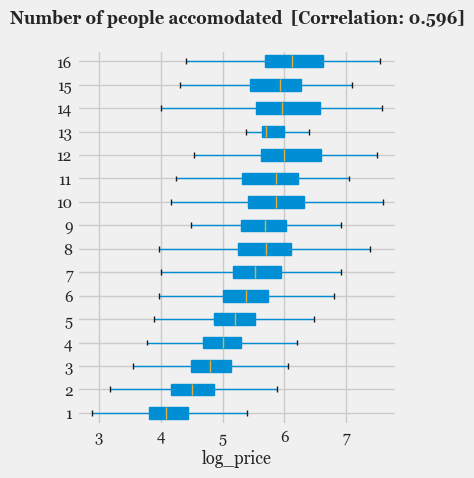

In [758]:
## numerical features:
    # log_price & accomodates
    # log_price & bathrooms
    # log_price & number_of_reviews
    # log_price & review_scores_rating
    # log_price & bedrooms
    # log_price & beds
    # log_price & amenities -> ***need to figure out***

# for correlation between log_price and no. of people accomodated
col = 'accommodates'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Number of people accomodated  [Correlation: " + str(cov) + "]"
plt_name = "accommodates"

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Number of Bathrooms  [Correlation: 0.368]')

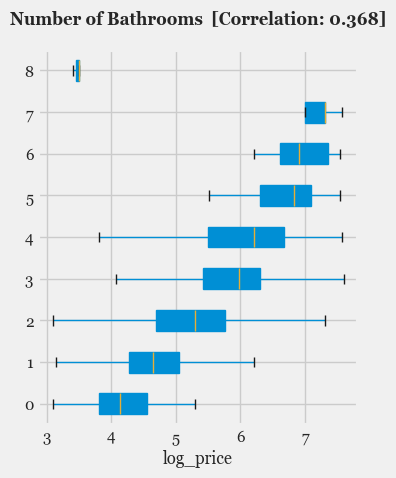

In [759]:
# for correlation between log_price and no. of bathrooms
col = 'bathrooms'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Number of Bathrooms  [Correlation: " + str(cov) + "]"
plt_name = 'bathrooms'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

In [760]:
# for correlation between log_price and no. of people accomodated
print(df['number_of_reviews'].unique())
print(df['review_scores_rating'].unique())
# these columns are too wide varitied to be spatially bivariated , hence use diff plot

[  2   6  10   4   3   9 159  82  29  13  15  12  26   5  57  73  14  40
   1 248  17 138  11  44  34  85  18  31  30  19  25  22  23  28   7  32
 144  16  38 105  59  67  21  61  87 206   8  43 104  47 186  36  27 167
  48 102  51 126  81  72  58  79  63  78  55  54  52  42  75 128  60  90
 254 135  64 191  24  66 139 125 129  74 318  33 187  35  37  20  70  39
  46  83  45  41  49 289 190  62  88 127 154 118 136  69 314 112  77  56
 181  99  53 117 101 106 255 114 110 192  76 113  91 123  84 146 119  86
  50  71 157  95 158 142  97 194 173 122 132 171  68 111 161 208 131 384
 216 133 116 148  89 156 179 147 145 202 150 258 120  98 178 200 155 163
 149 107  94 267 100  65 207 172 121 180  80  92 263 193 251 199 103 166
 237 290 137 153  96 425 185 140 168 162  93 360 141 246 195 196 109 273
 305 214 351 152 189 269 134 221 317 218 217 336 272 175 143 215 188 278
 383 160 203 165 115 108 256 198 323 465 302 469 220 204 170 182 480 287
 225 492 224 201 288 389 343 303 169 228 236 205 28

Text(0.5, 0, 'log_price')

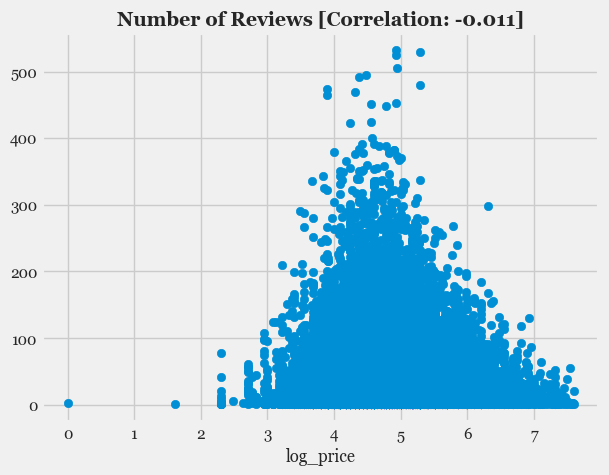

In [761]:
# for correlation between log_price and number_of_reviews
col = 'number_of_reviews'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
title = "Number of Reviews [Correlation: " + str(cov) + "]"
plt_name = 'number_of_reviews'

plt.scatter(dfcl['log_price'], df[col])
ax = plt.gca()
plt.title(title, fontsize=14, fontweight='bold') 
ax.set_xlabel('log_price', fontsize=12)

Text(0.5, 0, 'log_price')

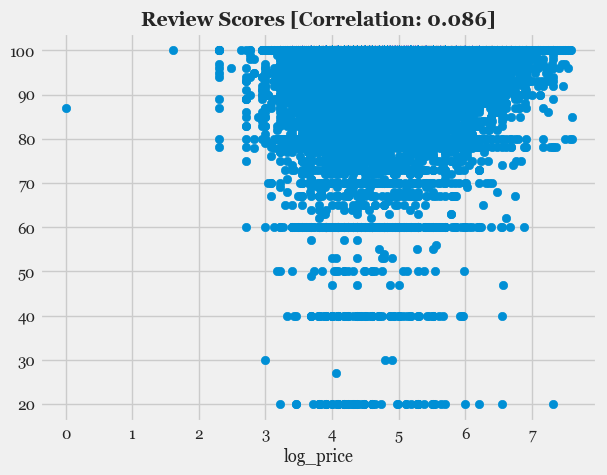

In [762]:
# for correlation between log_price and review_scores_rating
col = 'review_scores_rating'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
title = "Review Scores [Correlation: " + str(cov) + "]"
plt_name = 'review_scores_rating'

plt.scatter(dfcl['log_price'], df[col])
ax = plt.gca()
plt.title(title, fontsize=14, fontweight='bold') 
ax.set_xlabel('log_price', fontsize=12)

Text(0.5, 0.98, 'Number of Bedrooms  [Correlation: 0.492]')

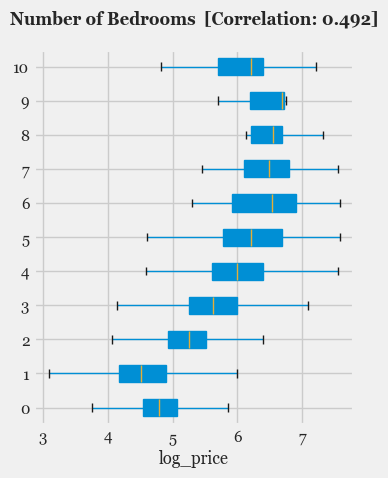

In [763]:
# for correlation between log_price and no. of bedrooms
col = 'bedrooms'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Number of Bedrooms  [Correlation: " + str(cov) + "]"
plt_name = 'bedrooms'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Beds [Correlation: 0.49]')

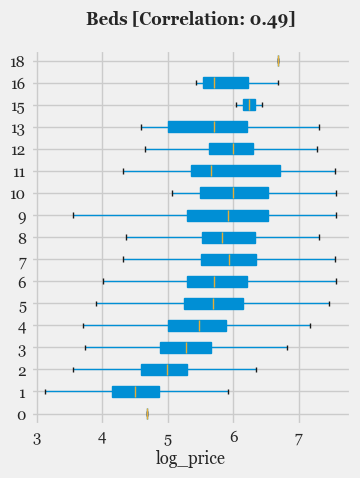

In [764]:
# for correlation between log_price and no. of beds
col = 'beds'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Beds [Correlation: " + str(cov) + "]"
plt_name = 'beds'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Host Has Profile Pic  [Correlation: -0.008]')

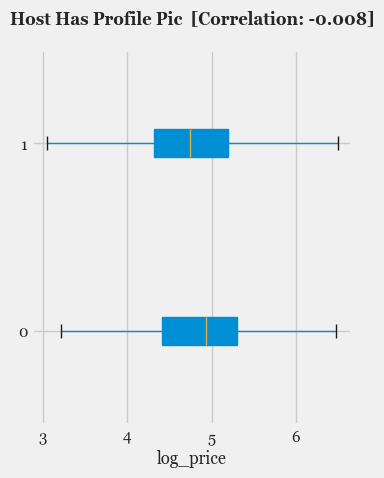

In [765]:
# host features:
    # log_price & host_has_profile_pic
    # log_price & host_identity_verified
    # log_price & host_response_rate
    # log_price & instant_bookable
# 
# for correlation between log_price and host_has_profile_pic
col = 'host_has_profile_pic'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Host Has Profile Pic  [Correlation: " + str(cov) + "]"
plt_name = 'host_has_profile_pic'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Host Identity Verified  [Correlation: 0.046]')

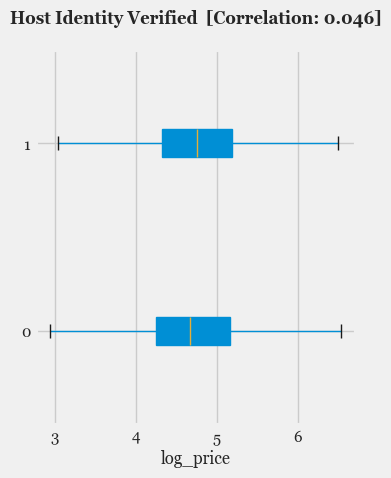

In [766]:
# for correlation between log_price and host_identity_verified
col = 'host_identity_verified'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Host Identity Verified  [Correlation: " + str(cov) + "]"
plt_name = 'host_identity_verified'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

Text(0.5, 0.98, 'Host Instant Bookable  [Correlation: -0.045]')

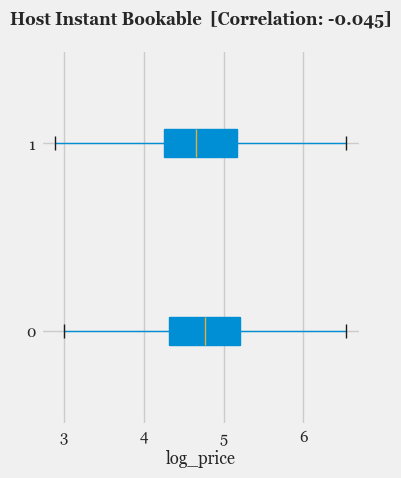

In [767]:
# for correlation between log_price and instant_bookable
col = 'instant_bookable'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
suptitle = "Host Instant Bookable  [Correlation: " + str(cov) + "]"
plt_name = 'instant_bookable'

dft = dfcl[[col, 'log_price']].copy()
dft[col] = dft[col].astype(int)
dft.boxplot(by=col, showfliers=False, figsize=(4,5), vert=False, patch_artist=True)

ax = plt.gca()
ax.set_title('')
ax.set_xlabel('log_price', fontsize=12)
ax.set_ylabel('')
plt.suptitle(suptitle, fontweight='bold', fontsize=12)

[  0 100  71  68  67  90  86  92  82  80  89  93  99  50  70  91  25  96
  95  98  62  88  29  81  63  38  60  79  75  65  94  97  87  40  33  58
  76  83  30  64  17  20  77  53  78  54  73  41  57  85  56  42  44  14
  10  72  84  55  43  74  36  39  46  26  61  59  52  22  15  69  27  11
  35  31  21  47  66]


Text(0.5, 0, 'log_price')

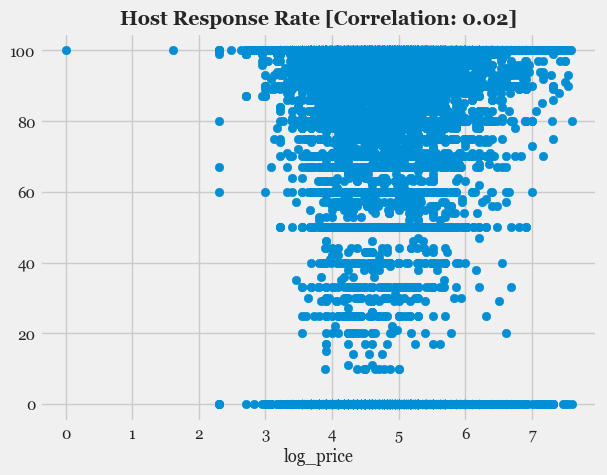

In [768]:
# for correlation between log_price and instant_bookable
print(df['host_response_rate'].unique())
# these columns are too wide varitied to be spatially bivariated , hence use diff plot
col = 'host_response_rate'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
title = "Host Response Rate [Correlation: " + str(cov) + "]"
plt_name = 'host_response_rate'

plt.scatter(dfcl['log_price'], df[col])
ax = plt.gca()
plt.title(title, fontsize=14, fontweight='bold') 
ax.set_xlabel('log_price', fontsize=12)

[100.          93.          92.          40.          99.
  97.          89.          91.          88.          86.
  72.          98.          96.          84.          95.
  78.09772821  94.          80.          87.          85.
  90.          70.          20.          76.          60.
  83.          82.          75.          73.          55.
  67.          71.          77.          79.          78.
  81.          47.          74.          68.          50.
  65.          53.          64.          69.          66.
  27.          62.          49.          57.          54.
  63.          30.          56.        ]


Text(0.5, 0, 'log_price')

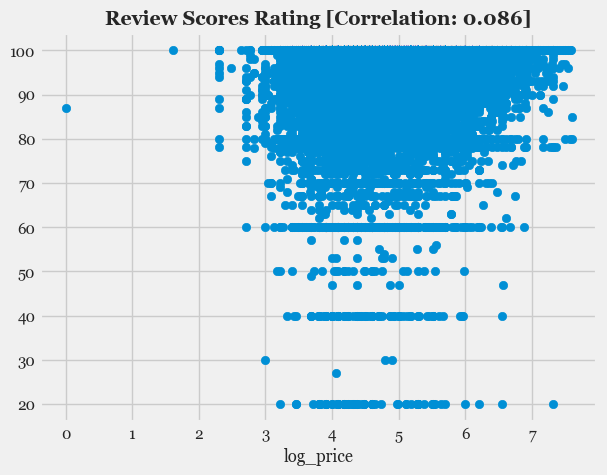

In [769]:
# for correlation between log_price and review_scores_rating
print(df['review_scores_rating'].unique())
# these columns are too wide varitied to be spatially bivariated , hence use diff plot
col = 'review_scores_rating'
cov = np.round(new_df[new_df["features"]==col]["correlation_with_price"].values[0], 3)
title = "Review Scores Rating [Correlation: " + str(cov) + "]"
plt_name = 'review_scores_rating'

plt.scatter(dfcl['log_price'], df[col])
ax = plt.gca()
plt.title(title, fontsize=14, fontweight='bold') 
ax.set_xlabel('log_price', fontsize=12)

In [770]:
# other possible interesting comparisons:
# city/ neighbourhood & review_scores_rating
dft_c = df[["city", "review_scores_rating"]].copy()
dft_c.groupby("city").mean().reset_index().sort_values("review_scores_rating", ascending=False)

,city,review_scores_rating
1,Chicago,95.185901
5,SF,94.925386
2,DC,94.607195
3,LA,94.206997
0,Boston,93.453888
4,NYC,93.257999


# 3. Geospatial Analysis:
## Task: Investigate the geographical data to understand regional pricing trends. 
Plot listings on a map using `latitude` and `longitude` data to visually assess price distribution. Examine if certain neighbourhoods or proximity to city centres influence pricing, providing a spatial perspective to the pricing strategy.

# 7. Model Development and Training:
## Task: Design and train predictive models to estimate `log_price`. 
Begin with a simple linear regression to establish a baseline, then explore more complex models such as RandomForest and GradientBoosting to 
better capture non-linear relationships and interactions between features. Document (briefly within Jupyter notebook itself) the model-building process, specifying the choice of algorithms and rationale.

# 8. Model Optimization and Validation:
## Task: Systematically optimize the models to achieve the best performance.
Employ techniques like grid search to experiment with different hyperparameters settings. Validate model choices through techniques 
like k-fold cross-validation, ensuring the model generalizes well to unseen data.

# 9. Feature Importance and Model Insights:
## Task: Analyze the trained models to identify which features most significantly impact `log_price`. 
Utilize model-specific methods like feature importance scores for tree-based models and SHAP values for an indepth understanding of feature contributions.

<Axes: >

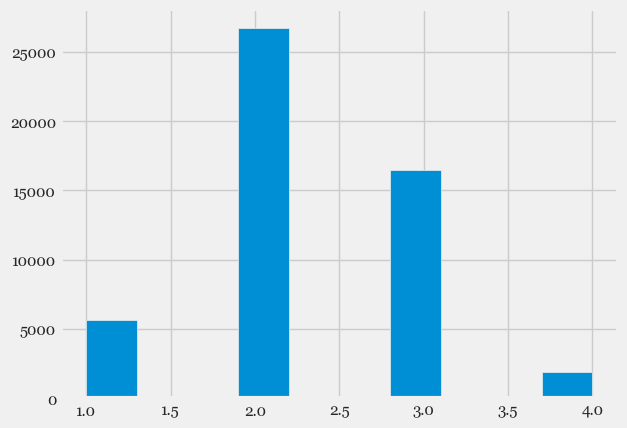

In [771]:
# Combined pipeline for both numerical and categorical features
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

# Pipeline for numerical features
# Select numerical columns only
numerical_attribs = ['accommodates', 'bathrooms', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'host_response_rate']
numerical_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

# Pipeline for categorical features
categorical_attribs = ['property_type', 'room_type', 'bed_type', 'city']
categorical_pipeline = Pipeline([
        ('ordinal_encoder', OrdinalEncoder()),
    ])
# Combined Pipeline for all features
preprocessing_pipeline = ColumnTransformer([
        ("categorical", categorical_pipeline, categorical_attribs),
        ("numerical", numerical_pipeline, numerical_attribs),
    ])

label = ['log_price']
df_attribs = dfcl[categorical_attribs + numerical_attribs + label].copy()
df_prepared = preprocessing_pipeline.fit_transform(dfcl[categorical_attribs + numerical_attribs])

# log_price categories
df_attribs['log_price_label'] = pd.cut(df['log_price'], bins=[0, 4, 5, 6, np.inf], labels=[1, 2, 3, 4])

# Distribution of class labels in overall dataset
df_attribs['log_price_label'].hist()


In [772]:
df_attribs[df_attribs['log_price_label'].isna()]
df_attribs = df_attribs.dropna()
df_attribs.isnull().sum()

property_type           0
room_type               0
bed_type                0
city                    0
accommodates            0
bathrooms               0
number_of_reviews       0
review_scores_rating    0
bedrooms                0
beds                    0
host_response_rate      0
log_price               0
log_price_label         0
dtype: int64

In [773]:
# Split Dataset into train and test sets
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
df_attribs.reset_index(inplace=True)
del df_attribs['index']

# Stratified split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(df_attribs, df_attribs['log_price_label']):
    strat_train_set = df_attribs.loc[train_index]
    strat_test_set = df_attribs.loc[test_index]

array([[<Axes: xlabel='review_scores_rating', ylabel='review_scores_rating'>,
        <Axes: xlabel='log_price', ylabel='review_scores_rating'>],
       [<Axes: xlabel='review_scores_rating', ylabel='log_price'>,
        <Axes: xlabel='log_price', ylabel='log_price'>]], dtype=object)

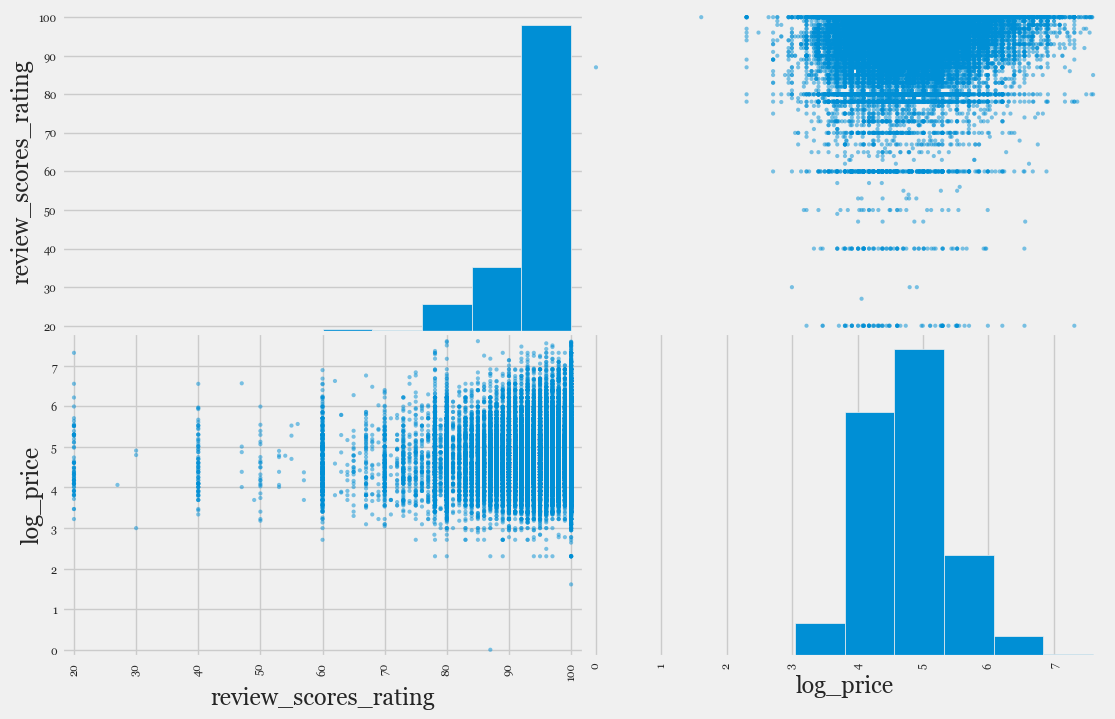

In [774]:
# Univariate, scatter matrix analysis
df_strat_train = strat_train_set.copy()
from pandas.plotting import scatter_matrix
attributes = ['review_scores_rating', 'log_price']
scatter_matrix(df[attributes], figsize=(12, 8))

In [775]:
# Prepare the data for Machine Learning algorithms
# drop labels for training set
df = strat_train_set.drop(['log_price', 'log_price_label'], axis=1) 
df_labels = strat_train_set['log_price'].copy()

In [776]:
# Model training and selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import joblib

def save_model(save_path, model):
    joblib.dump(model, save_path) # DIFF    

def load_model(load_path):
    my_model_loaded = joblib.load(load_path)
    return my_model_loaded
    
def display_scores(scores):
    print("Scores:", scores, "\n")
    print("Mean:", scores.mean(), "\n")
    print("Standard deviation:", scores.std(), "\n")
    

# Function to get grid search results
def get_hyperparameter_search_results(model, df_train, df_labels, search_type,
                                      param_grid, param_distributions, n_iter, cv):
    search_results = {}
    
    ## train across 5 folds, that's a total of (12+6)*5=90 rounds of training
    if search_type == "grid":
        search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                              scoring='neg_mean_squared_error', return_train_score=True)
    elif search_type == "randomized":
        search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                    n_iter=n_iter, cv=cv, scoring='neg_mean_squared_error', random_state=42,
                                    return_train_score=True)
    else:
        print("Invalid search type", "\n")
        return

    search.fit(df_train, df_labels)
    
    search_results["search"] = search
    search_results["best_params_"] = search.best_params_
    search_results["best_estimator_"] = search.best_estimator_
    search_results["cv_results_"] = search.cv_results_
    
    return search_results


def plot_feature_importance(best_estimator, df_train):
    X = df_train
    importances = best_estimator.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")
    for f in range(X.shape[1]):
       print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the impurity-based feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [777]:
from sklearn.model_selection import learning_curve

#train_sizes=[0.25, 0.5, 0.75, 1]
def get_model_pics(model, model_save_name, train_sizes_lc, train_sizes_fittime, ylim):
    train_sizes, train_scores, valid_scores, fit_times, score_times = learning_curve(model, df_prepared, df_labels, train_sizes=train_sizes_lc, cv=5, scoring="neg_mean_squared_error", return_times=True)
    
    train_rmse = np.sqrt(-train_scores)
    train_rmse_mean = np.mean(train_rmse, axis=1)
    train_rmse_std = np.std(train_rmse, axis=1)

    valid_rmse = np.sqrt(-valid_scores)
    valid_rmse_mean = np.mean(valid_rmse, axis=1)
    valid_rmse_std = np.std(valid_rmse, axis=1)

    
    ### Learning Curve
    plt.figure()
    plt.plot(train_sizes, train_rmse_mean, 'o-', linewidth=2, markersize=8)
    plt.fill_between(train_sizes, train_rmse_mean-2*train_rmse_std, train_rmse_mean+2*train_rmse_std, alpha=0.5)
    plt.plot(train_sizes, valid_rmse_mean, 'o-', linewidth=2, markersize=8)
    plt.fill_between(train_sizes, valid_rmse_mean-2*valid_rmse_std, valid_rmse_mean+2*valid_rmse_std, alpha=0.5)
    ax = plt.gca()
    ax.set_xscale('log')
    plt.title("Learning Curve", fontsize=16, fontweight="bold")
    plt.xlabel("Number of training examples", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.legend(["Training", "Validation"])

    
    ### Scalability of models
    # train_sizes=[0.25, 0.5, 0.75, 1]
    train_sizes, train_scores, valid_scores, fit_times, score_times = learning_curve(model, df_prepared, df_labels, train_sizes=train_sizes_fittime, cv=5, scoring="neg_mean_squared_error", return_times=True)

    valid_rmse = np.sqrt(-valid_scores)
    valid_rmse_mean = np.mean(valid_rmse, axis=1)
    valid_rmse_std = np.std(valid_rmse, axis=1)

    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    plt.figure()
    plt.plot(train_sizes, fit_times_mean, 'o-', linewidth=2, markersize=8, c="#e5ae38")
    plt.fill_between(train_sizes, fit_times_mean-2*fit_times_std, fit_times_mean+2*fit_times_std, alpha=0.5, color="#e5ae38")
    ax = plt.gca()
    ax.set_xscale('log')
    plt.title("Model Scalability", fontsize=16, fontweight="bold")
    plt.xlabel("Number of training examples", fontsize=14)
    plt.ylabel("Time to fit (seconds)", fontsize=14)
    
    ### Model performance
    plt.figure()
    plt.plot(fit_times_mean, train_rmse_mean, 'o-', linewidth=2, markersize=8, c="#6d904f")
    plt.fill_between(fit_times_mean, train_rmse_mean-2*train_rmse_std, train_rmse_mean+2*train_rmse_std, alpha=0.5, color="#6d904f")
    plt.title("Model Performance", fontsize=16, fontweight="bold")
    plt.ylabel("Training RMSE", fontsize=14)
    plt.xlabel("Time to fit (seconds)", fontsize=14)

In [778]:
##### LINEAR REGRESSION #####

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

model_linreg = LinearRegression()
df_prepared = preprocessing_pipeline.transform(df)
model_linreg.fit(df_prepared, df_labels)
#df_predictions = model_linreg.predict(df_prepared)

pipeline_linreg = Pipeline([
        ("preparation", preprocessing_pipeline),
        ("linear", model_linreg)
    ])
df_predictions = pipeline_linreg.predict(df)

mse_linreg = mean_squared_error(df_labels, df_predictions)
rmse_linreg = np.sqrt(mse_linreg)
print("RMSE: " + str(rmse_linreg))

mae_linreg = mean_absolute_error(df_labels, df_predictions)
print("MAE: " + str(mae_linreg))

r2score = r2_score(df_labels, df_predictions)
print("R2 Score: " + str(r2score))

scores_linreg = cross_val_score(model_linreg, df_prepared, df_labels,scoring="neg_mean_squared_error", cv=10)
rmsescores_linreg = np.sqrt(-scores_linreg)
display_scores(rmsescores_linreg)

RMSE: 0.4323270413371029
MAE: 0.3356503422093957
R2 Score: 0.5741343052986863
Scores: [0.43102971 0.43180817 0.42836742 0.41921459 0.43360709 0.44436798
 0.43572745 0.43039676 0.44437407 0.42513623] 

Mean: 0.43240294725295064 

Standard deviation: 0.0074044570241398695 



In [779]:
# Feature Selection
from sklearn.feature_selection import SelectKBest, RFE
from sklearn.feature_selection import f_regression

rfe = RFE(estimator=model_linreg, n_features_to_select=5, step=1)
rfe.fit(df_prepared, df_labels)
ranking = rfe.ranking_
ranking

array([6, 1, 4, 1, 1, 1, 7, 2, 1, 3, 5])

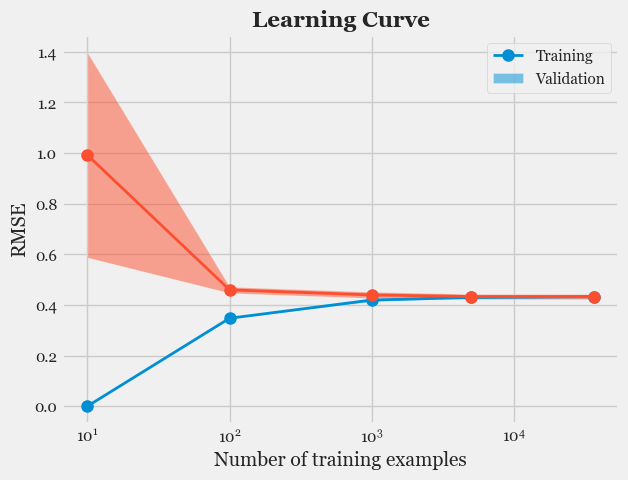

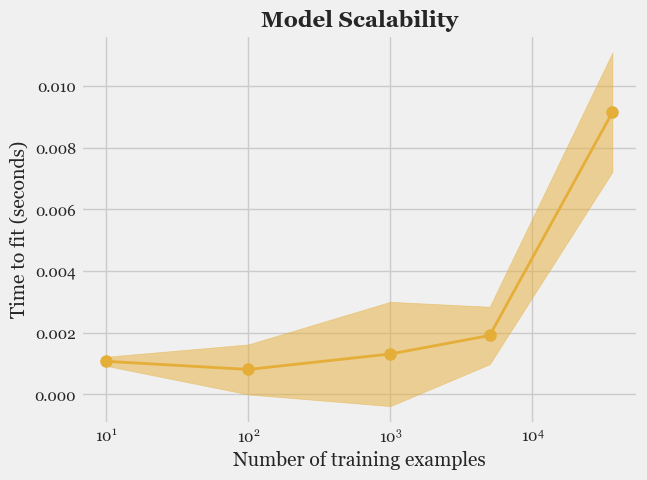

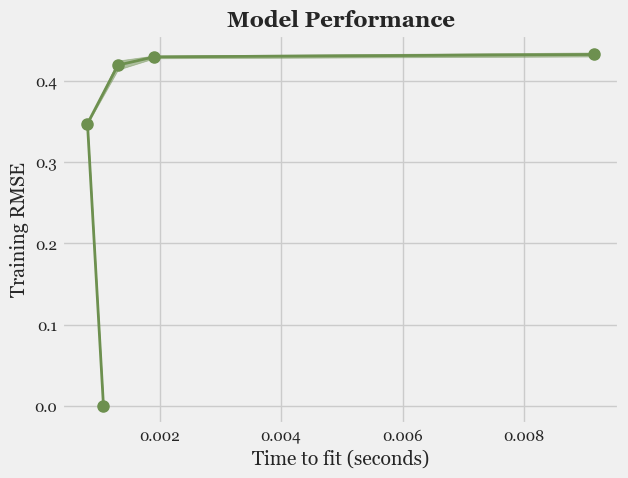

In [780]:
# Learning Curve, Model Scalability, Model performance
get_model_pics(model_linreg, "linreg", [10, 100, 1000, 5000, 36540],
               [10, 100, 1000, 5000, 36540], [0, 0.06])

In [781]:
# cross validation:
scores_linreg = cross_val_score(pipeline_linreg, df, df_labels, scoring="neg_mean_squared_error", cv=10)
rmsescores_linreg = np.sqrt(-scores_linreg)
display_scores(rmsescores_linreg)

Scores: [0.43102971 0.43180817 0.42836742 0.41921459 0.43360709 0.44436798
 0.43572745 0.43039676 0.44437407 0.42513623] 

Mean: 0.43240294725295064 

Standard deviation: 0.007404457024139817 



In [782]:
##### Decision Tree Regressor #####
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint


tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(df_prepared, df_labels)

df_predictions = tree_reg.predict(df_prepared)
tree_mse = mean_squared_error(df_labels, df_predictions)
tree_rmse = np.sqrt(tree_mse)
print("tree_rmse: ")
print(tree_rmse, "\n")

# Cross Validation
scores = cross_val_score(tree_reg, df_prepared, df_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print("tree_rmse_scores: ")
display_scores(tree_rmse_scores)
print("\n")


print("========= Decision Tree Regressor =========")
default_model_dectree = DecisionTreeRegressor(random_state=42)
default_model_dectree.fit(df_prepared, df_labels)
df_predictions = default_model_dectree.predict(df_prepared)

mse_default_model_dectree = mean_squared_error(df_labels, df_predictions)
rmse_default_model_dectree = np.sqrt(mse_default_model_dectree)
print("Model: ")
print(default_model_dectree, "\n")
print("Default Model RMSE Score: " + str(rmse_default_model_dectree), "\n")

scores = cross_val_score(default_model_dectree, df_prepared, df_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)
print("\n")


model_dectree = DecisionTreeRegressor(random_state=42)
param_grid = [
    {'max_depth': [1, 20, 100], 'max_features': [1, 5, 15, 20], 'max_leaf_nodes': [5, 50, 100]},
  ]
search_results_dectree = get_hyperparameter_search_results(model=model_dectree, df_train=df_prepared, df_labels=df_labels, search_type="grid", param_grid=param_grid, param_distributions=None, n_iter=5, cv=2)

# Best estimator (hyperparameter combination) found
print("========= Best Parameters: =========")
print(search_results_dectree["best_params_"], "\n")
print("========= Best Estimator: =========")
print(search_results_dectree["best_estimator_"], "\n")

print("========= Cross Validation Results =========")

# score of each hyperparameter combination tested during the grid search
cvres = search_results_dectree["cv_results_"]
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
    
best_dectree = search_results_dectree["best_estimator_"]

tree_rmse: 
0.18792282556851073 

tree_rmse_scores: 
Scores: [0.53524754 0.53927123 0.53307484 0.53638342 0.53679994 0.54213511
 0.54579404 0.53834771 0.54360153 0.53033716] 

Mean: 0.538099253106713 

Standard deviation: 0.00453285367784377 



========= Decision Tree Regressor =========
Model: 
DecisionTreeRegressor(random_state=42) 

Default Model RMSE Score: 0.18792282556851073 

Scores: [0.53524754 0.53927123 0.53307484 0.53638342 0.53679994 0.54213511
 0.54579404 0.53834771 0.54360153 0.53033716] 

Mean: 0.538099253106713 

Standard deviation: 0.00453285367784377 



========= Best Parameters: =========
{'max_depth': 20, 'max_features': 15, 'max_leaf_nodes': 100} 

========= Best Estimator: =========
DecisionTreeRegressor(max_depth=20, max_features=15, max_leaf_nodes=100,
                      random_state=42) 

========= Cross Validation Results =========
0.5849139179825883 {'max_depth': 1, 'max_features': 1, 'max_leaf_nodes': 5}
0.5849139179825883 {'max_depth': 1, 'max_features

Text(0.5, 1.0, 'Tuning Max Leaf Nodes (Max Depth=10, Max features=15)')

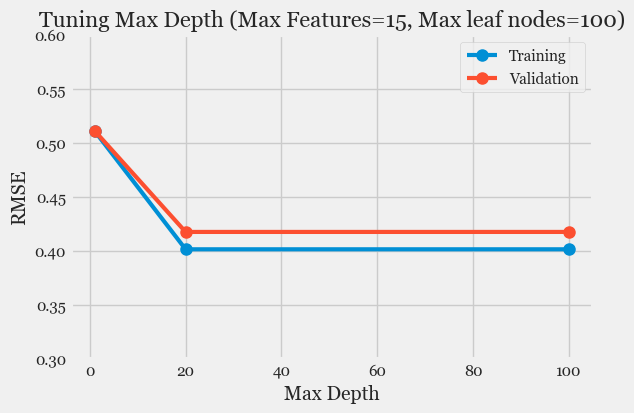

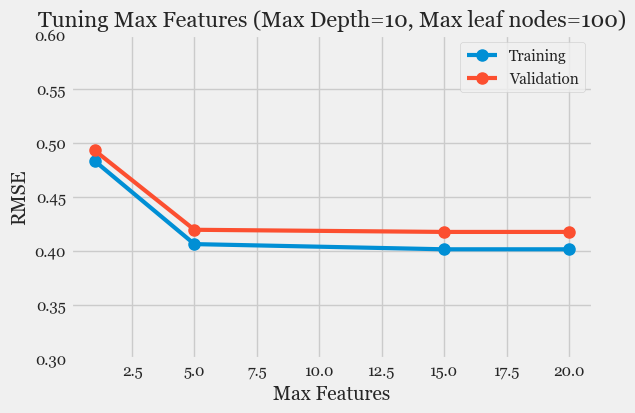

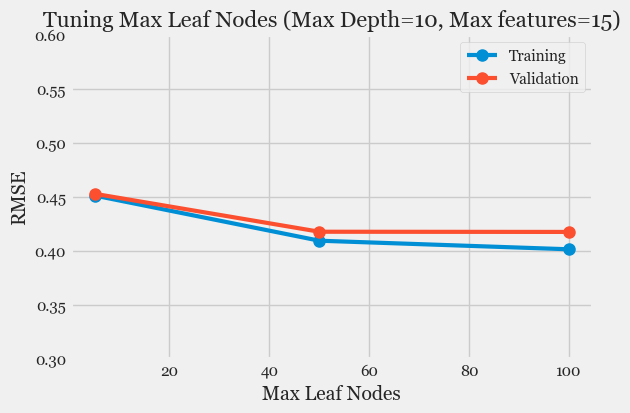

In [783]:
# Hyperparameter tuning

# Max Features
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_features = 15
max_leaf_nodes = 100
# for mean_score, evaluate params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_features"]==max_features) and (params["max_leaf_nodes"]==max_leaf_nodes):
        hparams.append(params["max_depth"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Depth", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([0.3, 0.6])
plt.title("Tuning Max Depth (Max Features=15, Max leaf nodes=100)", fontsize=16)

# Max Depth
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_depth = 20
max_leaf_nodes = 100
# for mean_score, evaluate params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_depth"]==max_depth) and (params["max_leaf_nodes"]==max_leaf_nodes):
        hparams.append(params["max_features"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Features", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([0.3, 0.6])
plt.title("Tuning Max Features (Max Depth=10, Max leaf nodes=100)", fontsize=16)


# Max leaf nodes
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_depth = 20
max_features = 15
# for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_depth"]==max_depth) and (params["max_features"]==max_features):
        hparams.append(params["max_leaf_nodes"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Leaf Nodes", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([0.3, 0.6])
plt.title("Tuning Max Leaf Nodes (Max Depth=10, Max features=15)", fontsize=16)

Text(0.5, 1.0, 'Feature Importance (Decision Tree)')

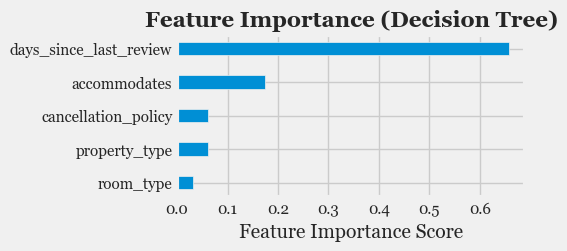

In [784]:
# Feature importance
features = dfcl.columns
score = best_dectree.feature_importances_
features_sorted = [x for y,x in sorted(zip(score, features))][::-1]
score_sorted = [y for y,x in sorted(zip(score, features))][::-1]

plt.figure(figsize=(4,2))
plt.barh(features_sorted[:5][::-1], score_sorted[:5][::-1], height=0.4)
plt.xlabel("Feature Importance Score", fontsize=14)
plt.title("Feature Importance (Decision Tree)", fontsize=16, fontweight="bold")

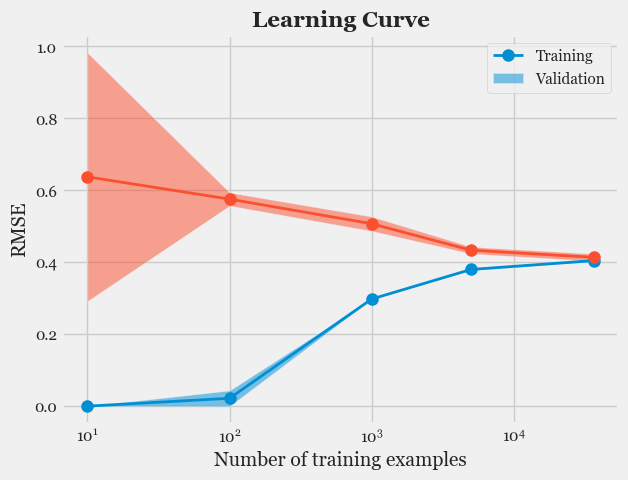

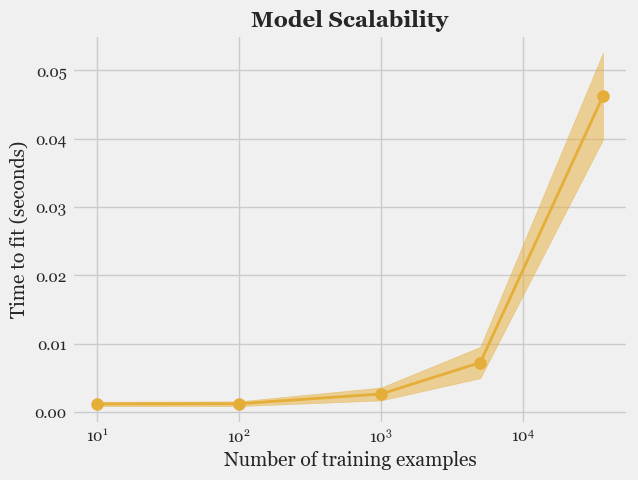

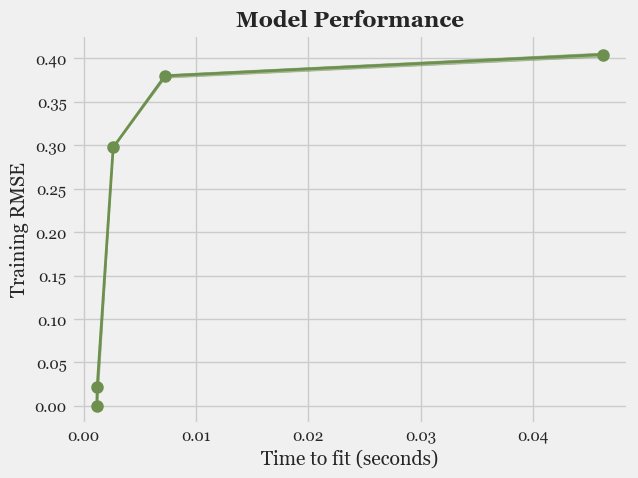

In [785]:
# Learning Curve, Model Scalability, Model performance
get_model_pics(best_dectree, "dectree", [10, 100, 1000, 5000, 36540],
               [10, 100, 1000, 5000, 36540], [0, 0.04])

In [786]:
##### Random Forest Regressor #####

from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from scipy import stats

# Regression with set fixed values of model parameters
default_model_rf = RandomForestRegressor(n_estimators=10, random_state=42)
default_model_rf.fit(df_prepared, df_labels)
df_predictions = default_model_rf.predict(df_prepared)
mse_default_model_rf = mean_squared_error(df_labels, df_predictions)
rmse_default_model_rf = np.sqrt(mse_default_model_rf)
print("rmse_default_model_rf: ")
print(rmse_default_model_rf, "\n")

# Cross Validation Scores
forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg, df_prepared, df_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print("forest_rmse_scores: ")
display_scores(forest_rmse_scores)
print("\n")

'''
# Grid Search (to find best parameters) CV
param_grid = [
    # tried 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then tried 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
forest_reg = RandomForestRegressor(random_state=42)
## train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(df_prepared, df_labels)

# Best estimator (hyperparameter combination) found
print(grid_search.best_params_, "\n")
print(grid_search.best_estimator_, "\n")

# score of each hyperparameter combination tested during the grid search
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

# Randomized Search (to find best parameters) CV 
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(df_prepared, df_labels)
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
'''

model_rf = RandomForestRegressor(random_state=42)
# can also add {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
param_grid = [
    {'n_estimators': [3, 10, 100], 'max_features': [2, 10, 20], 'max_depth': [2, 10, 100]},
  ]
search_results_rf = get_hyperparameter_search_results(model=model_rf, df_train=df_prepared, df_labels=df_labels, search_type="grid", param_grid=param_grid, param_distributions=[], n_iter=5, cv=2)
best_rf = search_results_rf["best_estimator_"]

# Best estimator (hyperparameter combination) found
print("======Best Parameters: ======")
print(search_results_rf["best_params_"], "\n")
print("======Best Estimator: ======")
print(search_results_rf["best_estimator_"], "\n")

print("====== Cross Validation Results ======")
# score of each hyperparameter combination tested during the grid search
cvres = search_results_rf["cv_results_"]
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

# Feature Importance
feature_importances = search_results_rf["best_estimator_"].feature_importances_
attributes = numerical_attribs + categorical_attribs

rmse_default_model_rf: 
0.24461345505336557 

orest_rmse_scores: 
Scores: [0.42484743 0.42199785 0.41943097 0.41845702 0.42635547 0.43864131
 0.43110157 0.42382634 0.43461037 0.41893751] 

Mean: 0.4258205839050106 

Standard deviation: 0.006570918552352281 



======Best Parameters: ======
{'max_depth': 10, 'max_features': 10, 'n_estimators': 100} 

======Best Estimator: ======
RandomForestRegressor(max_depth=10, max_features=10, random_state=42) 

====== Cross Validation Results ======
0.5086692496557221 {'max_depth': 2, 'max_features': 2, 'n_estimators': 3}
0.4917375542200938 {'max_depth': 2, 'max_features': 2, 'n_estimators': 10}
0.4960998549228288 {'max_depth': 2, 'max_features': 2, 'n_estimators': 100}
0.46234993784026135 {'max_depth': 2, 'max_features': 10, 'n_estimators': 3}
0.4535907350072908 {'max_depth': 2, 'max_features': 10, 'n_estimators': 10}
0.45486875472752253 {'max_depth': 2, 'max_features': 10, 'n_estimators': 100}
0.4623499378402613 {'max_depth': 2, 'max_features': 2

Text(0.5, 1.0, 'Tuning Num of estimators (Max Depth=10, Max features=10)')

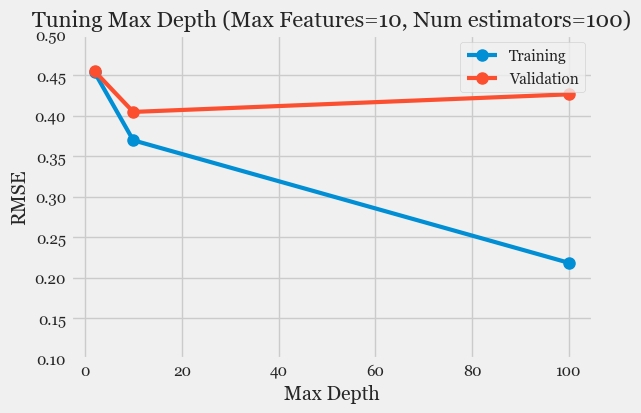

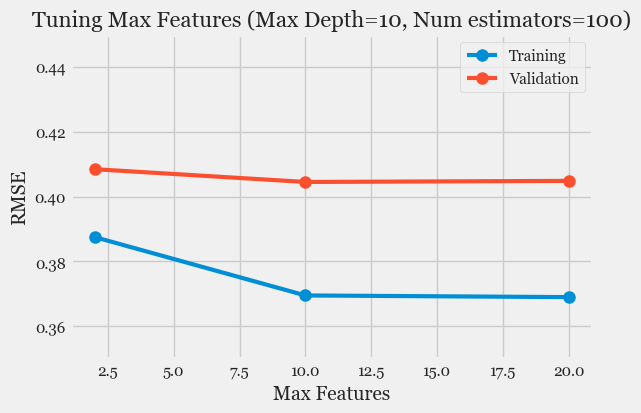

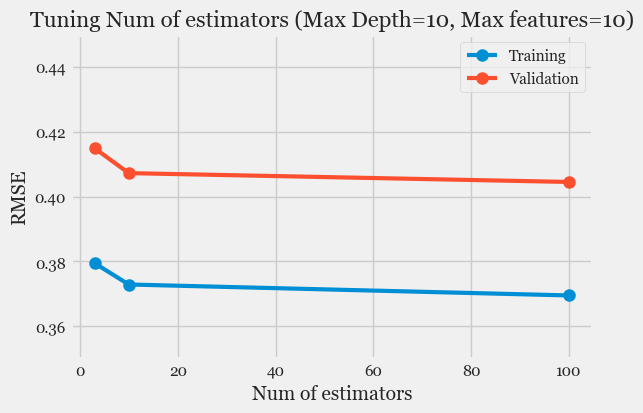

In [791]:
### Hyperparameter tuning

### Max Features
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_features = 10
n_estimators = 100
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_features"]==max_features) and (params["n_estimators"]==n_estimators):
        hparams.append(params["max_depth"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Depth", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([0.1, 0.5])
plt.title("Tuning Max Depth (Max Features="+str(max_features)+", Num estimators="+str(n_estimators)+")", fontsize=16)


### Max Depth
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_depth = 10
n_estimators = 100
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_depth"]==max_depth) and (params["n_estimators"]==n_estimators):
        hparams.append(params["max_features"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Max Features", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([0.35, 0.45])
plt.title("Tuning Max Features (Max Depth="+str(max_depth)+", Num estimators="+str(n_estimators)+")", fontsize=16)


### Max leaf nodes
hparams = []
hpscores_valid = []
hpscores_train = []
hpstd = []
max_depth = 10
max_features = 10
#for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
for i in range(len(cvres["params"])):
    params = cvres["params"][i]
    if (params["max_depth"]==max_depth) and (params["max_features"]==max_features):
        hparams.append(params["n_estimators"])
        hpscores_valid.append(np.sqrt(-cvres["mean_test_score"][i]))
        hpscores_train.append(np.sqrt(-cvres["mean_train_score"][i]))

plt.figure(figsize=(6,4))
plt.plot(hparams, hpscores_train, 'o-', linewidth=3, markersize=8)
plt.plot(hparams, hpscores_valid, 'o-', linewidth=3, markersize=8)
plt.legend(["Training", "Validation"])
plt.xlabel("Num of estimators", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.ylim([0.35, 0.45])
plt.title("Tuning Num of estimators (Max Depth="+str(max_depth)+", Max features="+str(max_features)+")", fontsize=16)

In [792]:
cvres

{'mean_fit_time': array([0.01288831, 0.02998424, 0.2215085 , 0.0211637 , 0.06065845,
        0.55617237, 0.0193553 , 0.05659902, 0.56344557, 0.02127779,
        0.06672692, 0.60700774, 0.06142104, 0.19777441, 2.0072161 ,
        0.06446171, 0.21399522, 2.19082284, 0.05426025, 0.17320454,
        1.83703697, 0.14247763, 0.44796062, 4.42765057, 0.14309871,
        0.48228014, 4.82896113]),
 'std_fit_time': array([7.68303871e-04, 3.02314758e-03, 3.28421593e-03, 2.07352638e-03,
        1.74307823e-03, 2.39441395e-02, 5.72204590e-05, 6.61611557e-05,
        2.29835510e-04, 6.33001328e-05, 2.89750099e-03, 1.63102150e-02,
        6.23345375e-04, 2.27332115e-03, 8.14759731e-03, 1.00135803e-05,
        1.26743317e-03, 5.90841770e-02, 2.50339508e-04, 2.94840336e-03,
        7.39153624e-02, 6.01112843e-03, 5.48744202e-03, 2.30339766e-02,
        3.37016582e-03, 4.84168530e-03, 3.91173363e-03]),
 'mean_score_time': array([0.00269961, 0.00538206, 0.03879821, 0.00227988, 0.00585878,
        0.042481

Text(0.5, 1.0, 'Feature Importance (Random Forest)')

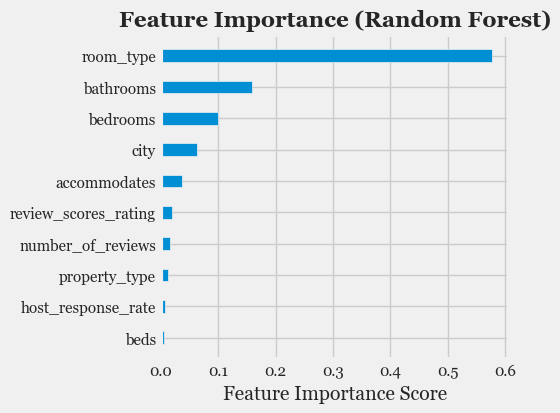

In [793]:
# Feature importance
features = df.columns
score = best_rf.feature_importances_
features_sorted = [x for y,x in sorted(zip(score, features))][::-1]
score_sorted = [y for y,x in sorted(zip(score, features))][::-1]

plt.figure(figsize=(4,4))
plt.barh(features_sorted[:10][::-1], score_sorted[:10][::-1], height=0.4)
plt.xlabel("Feature Importance Score", fontsize=14)
plt.title("Feature Importance (Random Forest)", fontsize=16, fontweight="bold")

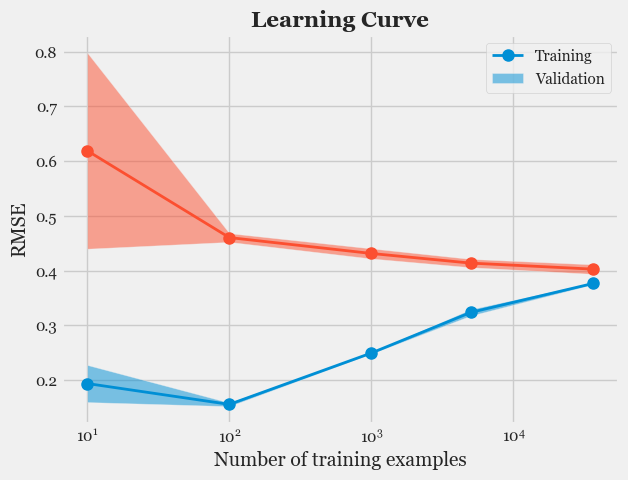

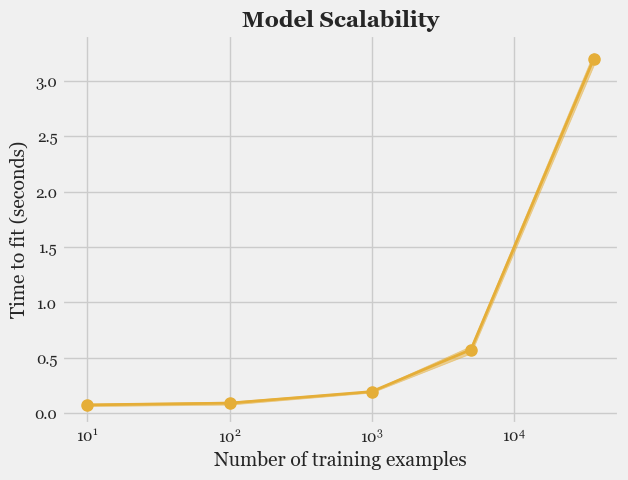

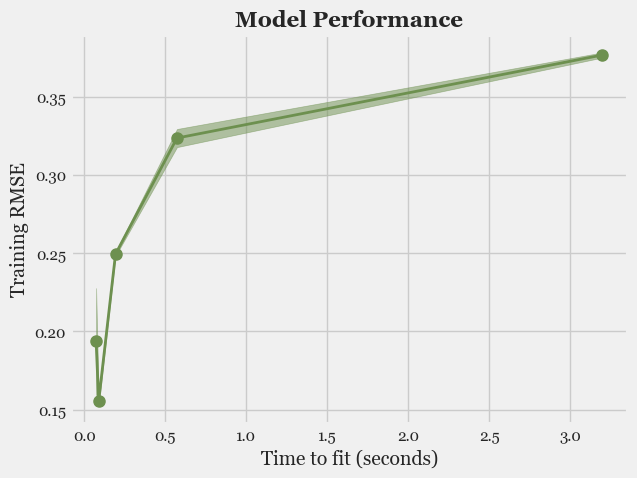

In [794]:
# Learning Curve, Model Scalability, Model performance
get_model_pics(best_rf, "rf", [10, 100, 1000, 5000, 36540],
               [10, 100, 1000, 5000, 36540], [0, 0.04])

In [797]:
##### XGBoost #####

from sklearn import datasets, ensemble
import xgboost as xgb

dfx = dfcl.copy()
del dfx["log_price"]
dfy = dfcl["log_price"].copy()
x_train, x_test, y_train, y_test = train_test_split(dfx,dfy, test_size=0.1, random_state=42)
xgb_train = xgb.DMatrix(x_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(x_test, y_test, enable_categorical=True)

params = {'n_estimators': 100,
          'max_depth': 10,
          'min_samples_split': 11,
          'learning_rate': 0.01}

default_model_xgb = ensemble.GradientBoostingRegressor(**params)
default_model_xgb.fit(df_prepared, df_labels)

xgbr_reg = xgb.XGBRegressor(objective ='reg:linear', n_estimators = 100, seed = 123) 
xgbr_reg.fit(x_train, y_train)
mse = mean_squared_error(y_test, xgbr_reg.predict(x_test))

default_xgb_scores = cross_val_score(default_model_xgb, df_prepared, df_labels,
                               scoring="neg_mean_squared_error", cv=2)
default_xgb_rmse_scores = np.sqrt(-default_xgb_scores)
display_scores(default_xgb_rmse_scores)

Scores: [0.44516275 0.45250076] 

Mean: 0.4488317515901846 

Standard deviation: 0.0036690039371436167 



# 10. Predictive Performance Assessment:
## Task: Critically evaluate the performance of the final model on a reserved test set. 
Use metrics such as Root Mean Squared Error (RMSE) and R-squared to assess accuracy and goodness of fit. Provide a detailed analysis of the residuals to check for any patterns that might suggest model biases or misfit

In [798]:
# Model comparison using test data results function declaration: 
def get_test_results(strat_test_set, preprocessing_pipeline, final_model):
    
    test_results = {}
    X_test = strat_test_set.drop(['log_price', 'log_price_label'], axis=1)
    y_test = strat_test_set['log_price'].copy()

    ### Full pipeline with pre-processing and model
    full_pipeline = Pipeline([
            ("preparation", preprocessing_pipeline),
            ("model", final_model)
        ])
    final_predictions = full_pipeline.predict(X_test)
    final_mse = mean_squared_error(y_test, final_predictions)
    final_rmse = np.sqrt(final_mse)

    ## 95% confidence interval for the test RMSE
    confidence = 0.95
    squared_errors = (final_predictions - y_test) ** 2
    mean = squared_errors.mean()
    m = len(squared_errors)

    confidence_interval_95 = np.sqrt(stats.t.interval(confidence, m - 1,
                             loc=np.mean(squared_errors),
                             scale=stats.sem(squared_errors)))
    
    test_results["labels"] = y_test
    test_results["predictions"] = final_predictions
    test_results["squared_errors"] = squared_errors
    test_results["mse"] = final_mse
    test_results["rmse"] = final_rmse
    test_results["errors"] = np.sqrt(squared_errors)
    test_results["interval_95"] = confidence_interval_95
    
    return test_results

In [799]:
linreg = get_test_results(strat_test_set, preprocessing_pipeline, model_linreg)
dectree = get_test_results(strat_test_set, preprocessing_pipeline, best_dectree)
rf = get_test_results(strat_test_set, preprocessing_pipeline, best_rf)
xgb = get_test_results(strat_test_set, preprocessing_pipeline, default_model_xgb)

Text(0.5, 1.0, 'Model Comparison on Test Data ')

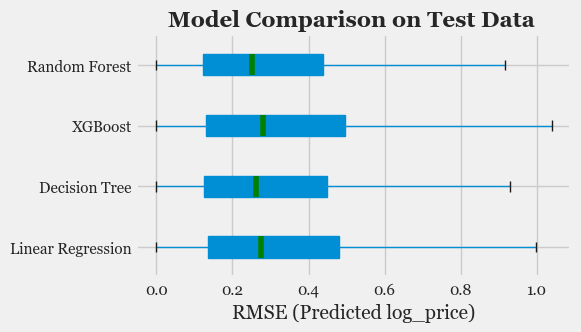

In [801]:
dft = pd.DataFrame()
dft["Linear Regression"] = linreg["errors"]
dft["Decision Tree"] = dectree["errors"]
dft["XGBoost"] = xgb["errors"]
dft["Random Forest"] = rf["errors"]
plt.figure(figsize=(5,3))
dft.boxplot(showfliers=False, patch_artist=True, medianprops=dict(linestyle='-', linewidth=4, color='green'), vert=False, widths=0.35)
ax = plt.gca()
ax.set_xlabel("RMSE (Predicted log_price)", fontsize=14)
ax.set_title("Model Comparison on Test Data ", fontsize=16, fontweight="bold")